In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs,\
                                  pad_seqs_2step, pad_seqs_1step, calculate_output, onehot2seq 

from sklearn.metrics import r2_score
import math

In [2]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        y = 1/math.sqrt(hidden_size)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model

def change_padder(seqs, cue_dict, xval):
    """ changes value of X from zero to a new value
        and recalculates sequence output"""
    cue_dict['X'] = xval
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, cue_dict, bidmas = False))

    return inps, cue_dict

def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict, bidmas = False))

    return inps, cue_dict

def predcorr(mods, tests):
    dfs1 = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
        all_dfs1 = pd.concat(dfs1) 
        preds, labs = all_dfs1['pred'], all_dfs1['label']
        xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)

        for d in dfs1:
            plt.scatter(d['label'], d['pred'])
        plt.plot(xy,xy)
        plt.xlabel('Ground truth')
        plt.ylabel('Model prediction')
        plt.title('with primitive training, R^2 = ' + str(round(r2_score(all_dfs1['pred'],all_dfs1['label']), 2)) )
        df_final = all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False)
        print(df_final)
    
    return df_final

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)

In [3]:
def generate_other(operators, inputs, init_values, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        for init in init_values:
            input_ids = [val for val in inputs if val != init]
            combi_inputcue = list(itertools.combinations(input_ids, r=2))
            cue = random.choice(combi_inputcue)
            op = random.choice(combi_operators)
            trial = [init,*zip(tuple(op), cue)]
            trial.append(calculate_output(trial, cue_dict, False))
            seq.append(trial)

    return seq

def test_other(operators, test, syms, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        input_ids = [test] + [random.choice(syms)]
        random.shuffle(input_ids)
        combi_inputcue = list(itertools.combinations(input_ids, r=2))
        cue = random.choice(combi_inputcue)
        op = random.choice(combi_operators)
        trial = [random.choice(syms),*zip(tuple(op), cue)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)

    return seq

def generate_self(operators, inputs, rep = 1):
    seq = []
    for _ in range(rep):
        for inp in inputs:
            trial = generate_sequences(operators, inp, len_seq = 2, cue_dict = cue_dict, init_values = inp)
            seq += trial
    return seq

def generate_dummy(operators, inputs, init_values, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        for init in init_values:
            input_ids = [val for val in inputs if val != init]
            inp = random.choice(input_ids)
            cue = (inp, inp)
            op = random.choice(combi_operators)
            trial = [init,*zip(tuple(op), cue)]
            trial.append(calculate_output(trial, cue_dict, False))
            seq.append(trial)

    return seq

def generate_other_1step(operators, inputs, init_values):
    # remove init form inputs
    
    seq = []
    for init in init_values:
        input_ids = [val for val in inputs if val != init]
        cue = random.sample(input_ids, 2)
        op = random.choice(operators)
        trial = [init,(op, cue[0])]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)
        op = random.choice(operators)
        trial = [cue[1],(op, init)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)

    return seq

def generate_min_other(operators, inputs, init_values):

    seq = []
    for inp in inputs:
        inits = [val for val in init_values if val != inp]
        init = random.choice(inits)
        op = random.choice(operators)
        trial = [init,(op, inp)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)
        
    return seq


def generate_Xother(operators, inputs):
    # remove init form inputs
    
    seq = []
    for inp in inputs:
        op = random.choice(operators)
        trial = ['X',(op, inp)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)
        
    return seq

def generate_self_1step(operators, inputs, init_values):  
    seq = []
    for init in init_values:
        op = random.choice(operators)
        trial = [init,(op, init)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)
    
    return seq


# Parameters and Setup

In [16]:
def run_exp1(trainseqs_old, testseqs_old1, testseqs_old2):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs, cd = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs1, cd = change_dict(testseqs_old1, cue_dict)
    test_inputs = convert_seq2inputs(testseqs1, num_classes=num_classes, seq_len=5)
    testset1 = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    testseqs2, cd = change_dict(testseqs_old2, cue_dict)
    test_inputs = convert_seq2inputs(testseqs2, num_classes=num_classes, seq_len=5)
    testset2 = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset1, testset2], epochs)

    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test1': testset1,'test2': testset2}

In [5]:
num_inputs = 7

total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,30))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {'X':0}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]


In [6]:
ops = ['-']
p = pad_seqs_1step(all_syms, cue_dict, padder = ('-', 'X'))
trainseqs = pad_seqs_2step(generate_other_1step(ops, all_syms[1:], all_syms[1:]), padder = ('-', 'X')) + p
testseqs1 = test_other(ops, 'B', all_syms[1:], rep = 10)
testseqs2 = test_other(ops, 'A', all_syms[1:], rep = 10)

In [120]:
trainseqs

[['B', ('-', 'E'), ('-', 'X'), 6],
 ['B', ('-', 'X'), ('-', 'E'), 6],
 ['G', ('-', 'B'), ('-', 'X'), 2],
 ['G', ('-', 'X'), ('-', 'B'), 2],
 ['C', ('-', 'F'), ('-', 'X'), 15],
 ['C', ('-', 'X'), ('-', 'F'), 15],
 ['G', ('-', 'C'), ('-', 'X'), -12],
 ['G', ('-', 'X'), ('-', 'C'), -12],
 ['D', ('-', 'B'), ('-', 'X'), 11],
 ['D', ('-', 'X'), ('-', 'B'), 11],
 ['C', ('-', 'D'), ('-', 'X'), 3],
 ['C', ('-', 'X'), ('-', 'D'), 3],
 ['E', ('-', 'G'), ('-', 'X'), -8],
 ['E', ('-', 'X'), ('-', 'G'), -8],
 ['B', ('-', 'E'), ('-', 'X'), 6],
 ['B', ('-', 'X'), ('-', 'E'), 6],
 ['F', ('-', 'C'), ('-', 'X'), -15],
 ['F', ('-', 'X'), ('-', 'C'), -15],
 ['B', ('-', 'F'), ('-', 'X'), 1],
 ['B', ('-', 'X'), ('-', 'F'), 1],
 ['G', ('-', 'E'), ('-', 'X'), 8],
 ['G', ('-', 'X'), ('-', 'E'), 8],
 ['B', ('-', 'G'), ('-', 'X'), -2],
 ['B', ('-', 'X'), ('-', 'G'), -2],
 ['A', ('-', 'X'), ('-', 'X'), 29],
 ['B', ('-', 'X'), ('-', 'X'), 13],
 ['C', ('-', 'X'), ('-', 'X'), 27],
 ['D', ('-', 'X'), ('-', 'X'), 24],


In [14]:
# params
num_classes = 22
batchsize=1
# specs
input_size = num_classes
output_size = 1
num_layers = 2
hidden_size = 10
num_sims = 32
learningRate = 0.005
epochs = 1000

# Different inits: Kaiming uniform

In [18]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in')


time:  4.760393031438192
                           label      pred  acc
trial                                          
['B', '-', 'A', '-', 'B']  -17.0 -8.245811  0.0
['B', '-', 'B', '-', 'A']  -17.0 -3.686089  0.0
['C', '-', 'A', '-', 'D']  -19.0 -7.067356  0.0
['D', '-', 'A', '-', 'E']  -18.0 -5.440248  0.0
['D', '-', 'A', '-', 'G']  -20.0 -4.956012  0.0
['D', '-', 'B', '-', 'A']  -10.0 -2.570275  0.0
['E', '-', 'A', '-', 'G']  -19.0 -4.104812  0.0
['E', '-', 'D', '-', 'A']  -16.0 -2.059275  0.0
['G', '-', 'B', '-', 'A']   -7.0 -3.277646  0.0
                           label      pred  acc
trial                                          
['B', '-', 'A', '-', 'B']  -17.0 -7.165158  0.0
['B', '-', 'B', '-', 'A']  -17.0 -5.036729  0.0
['C', '-', 'A', '-', 'D']  -19.0 -7.446677  0.0
['D', '-', 'A', '-', 'E']  -18.5 -5.687037  0.0
['D', '-', 'A', '-', 'G']  -24.0 -8.871514  0.0
['D', '-', 'B', '-', 'A']  -15.5 -4.946132  0.0
['E', '-', 'A', '-', 'G']  -22.5 -7.629529  0.0
['E', '-', 'D',

                               label      pred       acc
trial                                                   
['B', '-', 'B', '-', 'A']  -9.368421 -1.406289  0.105263
['C', '-', 'A', '-', 'D']  -8.263158 -1.974245  0.105263
['G', '-', 'B', '-', 'A']  -8.368421 -1.483360  0.052632
['B', '-', 'A', '-', 'B']  -9.368421 -2.868718  0.000000
['D', '-', 'A', '-', 'E']  -7.421053 -1.088037  0.000000
['D', '-', 'A', '-', 'G'] -11.526316 -3.469539  0.000000
['D', '-', 'B', '-', 'A'] -10.526316 -2.606769  0.000000
['E', '-', 'A', '-', 'G'] -13.473684 -4.219930  0.000000
['E', '-', 'D', '-', 'A'] -11.315789 -3.461570  0.000000
                           label      pred   acc
trial                                           
['B', '-', 'B', '-', 'A']  -9.35 -1.344547  0.10
['C', '-', 'A', '-', 'D']  -8.15 -1.822083  0.10
['G', '-', 'B', '-', 'A']  -8.25 -1.387178  0.05
['B', '-', 'A', '-', 'B']  -9.35 -2.758484  0.00
['D', '-', 'A', '-', 'E']  -8.10 -1.253580  0.00
['D', '-', 'A', '-', 'G'] -11.

label      pred      acc
trial                                                 
['B', '-', 'B', '-', 'A']  -9.21875 -1.465469  0.06250
['C', '-', 'A', '-', 'D']  -9.46875 -2.984228  0.06250
['D', '-', 'A', '-', 'G']  -9.59375 -2.915908  0.03125
['D', '-', 'B', '-', 'A'] -10.06250 -2.745263  0.03125
['G', '-', 'B', '-', 'A']  -9.68750 -2.394529  0.03125
['B', '-', 'A', '-', 'B']  -9.21875 -2.914458  0.00000
['D', '-', 'A', '-', 'E']  -6.62500 -0.994969  0.00000
['E', '-', 'A', '-', 'G'] -12.18750 -3.955336  0.00000
['E', '-', 'D', '-', 'A'] -11.81250 -3.637019  0.00000

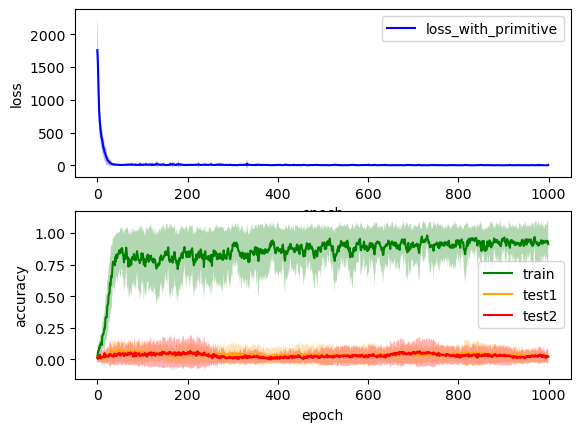

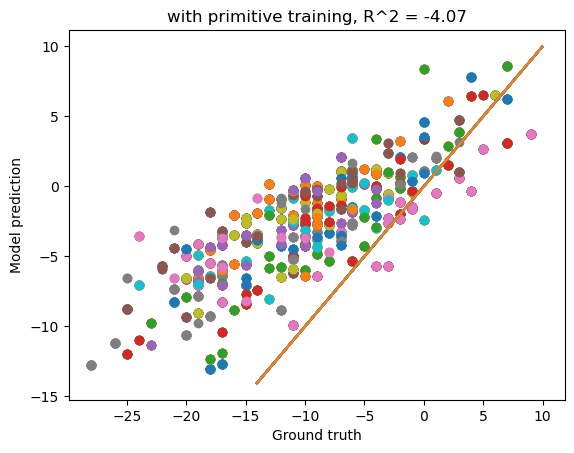

In [19]:
num_layers = 1
hidden_size = 20
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

In [23]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_out')


time:  6.057690954208374
                           label       pred  acc
trial                                           
['D', '-', 'A', '-', 'E']   -2.0  -1.553400  1.0
['B', '-', 'A', '-', 'B']   -9.0  -4.503151  0.0
['B', '-', 'B', '-', 'A']   -9.0  -1.016664  0.0
['C', '-', 'A', '-', 'D']  -20.0 -11.437221  0.0
['D', '-', 'A', '-', 'G']   -7.0  -4.040470  0.0
['D', '-', 'B', '-', 'A']   -4.0   1.946602  0.0
['E', '-', 'A', '-', 'G']  -14.0  -5.381739  0.0
['E', '-', 'D', '-', 'A']  -16.0  -4.939599  0.0
['G', '-', 'B', '-', 'A']   -6.0   1.686703  0.0
                           label      pred  acc
trial                                          
['D', '-', 'A', '-', 'E']   -9.0 -4.940316  0.5
['B', '-', 'A', '-', 'B']  -13.0 -4.389026  0.0
['B', '-', 'B', '-', 'A']  -13.0 -3.059531  0.0
['C', '-', 'A', '-', 'D']  -16.5 -8.788390  0.0
['D', '-', 'A', '-', 'G']   -8.5 -4.052984  0.0
['D', '-', 'B', '-', 'A']  -11.0 -1.709409  0.0
['E', '-', 'A', '-', 'G']  -12.5 -5.787329  0.0
['E'

                           label      pred   acc
trial                                           
['D', '-', 'A', '-', 'E']  -8.95 -2.552714  0.15
['B', '-', 'B', '-', 'A']  -9.85 -2.330605  0.05
['D', '-', 'A', '-', 'G'] -10.25 -3.747366  0.05
['E', '-', 'A', '-', 'G'] -11.15 -4.264328  0.05
['B', '-', 'A', '-', 'B']  -9.85 -3.770309  0.00
['C', '-', 'A', '-', 'D'] -10.35 -3.577914  0.00
['D', '-', 'B', '-', 'A']  -9.05 -1.749882  0.00
['E', '-', 'D', '-', 'A'] -10.75 -2.224729  0.00
['G', '-', 'B', '-', 'A']  -8.65 -1.496649  0.00
                               label      pred       acc
trial                                                   
['D', '-', 'A', '-', 'E']  -8.666667 -2.343465  0.142857
['B', '-', 'B', '-', 'A'] -10.047619 -2.398244  0.047619
['D', '-', 'A', '-', 'G'] -10.476190 -3.952953  0.047619
['E', '-', 'A', '-', 'G'] -11.857143 -4.580863  0.047619
['B', '-', 'A', '-', 'B'] -10.047619 -3.822365  0.000000
['C', '-', 'A', '-', 'D'] -11.142857 -3.879018  0.000000
['D',

label      pred      acc
trial                                                 
['D', '-', 'A', '-', 'E']  -7.93750 -1.551131  0.12500
['D', '-', 'A', '-', 'G']  -9.59375 -2.757966  0.06250
['B', '-', 'B', '-', 'A']  -9.65625 -2.032277  0.03125
['C', '-', 'A', '-', 'D'] -10.34375 -3.757202  0.03125
['D', '-', 'B', '-', 'A']  -8.40625 -1.332623  0.03125
['E', '-', 'A', '-', 'G'] -11.31250 -3.869281  0.03125
['G', '-', 'B', '-', 'A']  -8.46875 -1.613137  0.03125
['B', '-', 'A', '-', 'B']  -9.65625 -3.252117  0.00000
['E', '-', 'D', '-', 'A'] -11.37500 -3.113708  0.00000

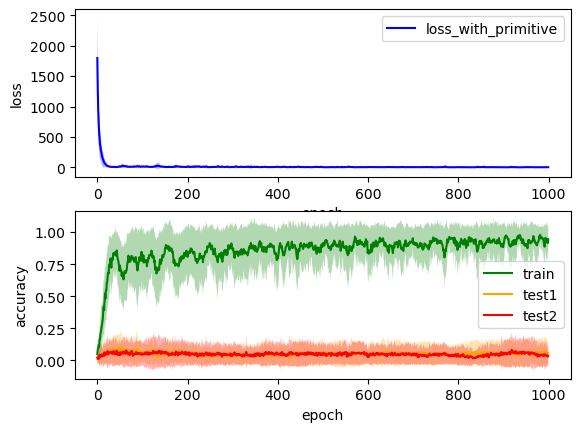

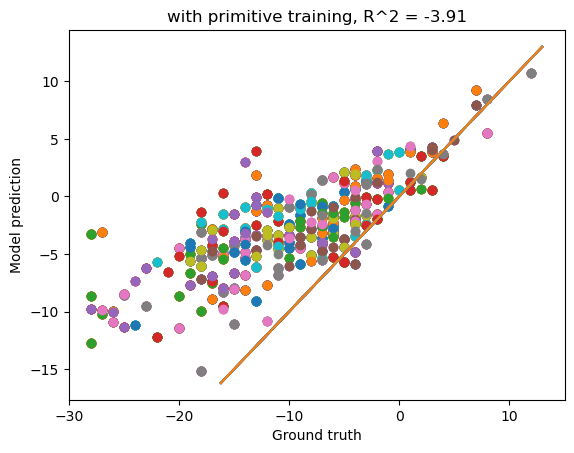

In [24]:
num_layers = 1
hidden_size = 20
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

In [25]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)


time:  5.79375383456548
                           label       pred  acc
trial                                           
['C', '-', 'A', '-', 'D']   -5.0  -5.238811  1.0
['D', '-', 'A', '-', 'E']    5.0   5.271497  1.0
['D', '-', 'A', '-', 'G']   11.0  10.611078  1.0
['B', '-', 'A', '-', 'B']   -2.0  -1.033738  0.0
['B', '-', 'B', '-', 'A']   -2.0   0.333608  0.0
['D', '-', 'B', '-', 'A']    9.0  10.648236  0.0
['E', '-', 'A', '-', 'G']    4.0   3.123269  0.0
['E', '-', 'D', '-', 'A']   -9.0  -8.032252  0.0
['G', '-', 'B', '-', 'A']   -4.0  -1.179125  0.0
                           label      pred  acc
trial                                          
['D', '-', 'A', '-', 'E']    0.0 -0.078786  1.0
['B', '-', 'B', '-', 'A']   -4.0 -2.960943  0.5
['C', '-', 'A', '-', 'D']   -7.0 -7.697939  0.5
['D', '-', 'A', '-', 'G']    0.5 -0.094265  0.5
['E', '-', 'D', '-', 'A']   -8.0 -7.488447  0.5
['G', '-', 'B', '-', 'A']   -7.0 -5.576233  0.5
['B', '-', 'A', '-', 'B']   -4.0 -2.907198  0.0
['D',

                               label      pred       acc
trial                                                   
['D', '-', 'A', '-', 'E'] -10.000000 -4.298979  0.190476
['B', '-', 'B', '-', 'A'] -10.142857 -5.772162  0.142857
['D', '-', 'A', '-', 'G']  -9.285714 -4.781918  0.095238
['E', '-', 'D', '-', 'A'] -10.285714 -4.496996  0.095238
['G', '-', 'B', '-', 'A'] -11.523810 -6.217062  0.095238
['C', '-', 'A', '-', 'D']  -9.619048 -4.633845  0.047619
['E', '-', 'A', '-', 'G']  -9.428571 -3.667905  0.047619
['B', '-', 'A', '-', 'B'] -10.142857 -5.499130  0.000000
['D', '-', 'B', '-', 'A'] -10.666667 -5.202215  0.000000
                               label      pred       acc
trial                                                   
['D', '-', 'A', '-', 'E'] -10.136364 -4.678575  0.227273
['B', '-', 'B', '-', 'A'] -10.363636 -5.800460  0.136364
['D', '-', 'A', '-', 'G']  -9.636364 -5.338213  0.136364
['E', '-', 'D', '-', 'A'] -10.590909 -4.620254  0.090909
['G', '-', 'B', '-', 'A'] -11.8

label      pred      acc
trial                                                 
['D', '-', 'A', '-', 'E']  -9.03125 -4.515641  0.15625
['B', '-', 'B', '-', 'A']  -9.31250 -5.993985  0.09375
['D', '-', 'A', '-', 'G']  -8.53125 -5.131234  0.09375
['E', '-', 'D', '-', 'A']  -9.59375 -5.085850  0.09375
['C', '-', 'A', '-', 'D']  -8.15625 -4.678513  0.06250
['G', '-', 'B', '-', 'A'] -11.31250 -7.245560  0.06250
['D', '-', 'B', '-', 'A'] -10.53125 -6.299300  0.03125
['E', '-', 'A', '-', 'G']  -8.81250 -4.714571  0.03125
['B', '-', 'A', '-', 'B']  -9.31250 -6.355441  0.00000

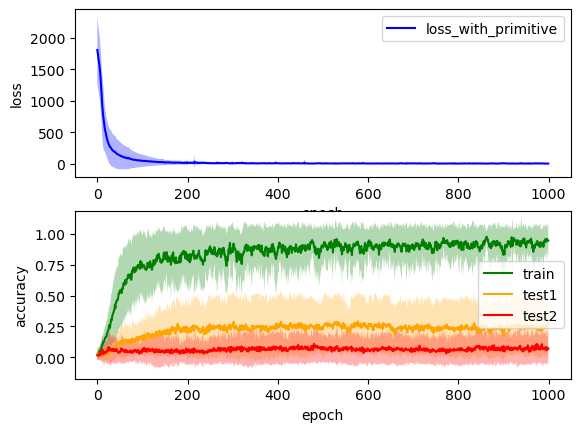

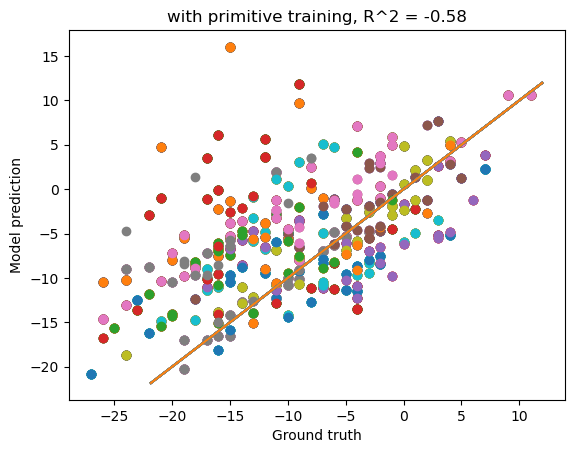

In [26]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

In [28]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)


time:  5.921701530615489
                           label      pred  acc
trial                                          
['C', '-', 'A', '-', 'D']   -5.0 -4.696007  1.0
['B', '-', 'A', '-', 'B']   -3.0 -5.001343  0.0
['B', '-', 'B', '-', 'A']   -3.0 -1.193799  0.0
['D', '-', 'A', '-', 'E']   10.0  7.860893  0.0
['D', '-', 'A', '-', 'G']    5.0  2.516686  0.0
['D', '-', 'B', '-', 'A']   -2.0 -1.001302  0.0
['E', '-', 'A', '-', 'G']   -8.0 -4.390844  0.0
['E', '-', 'D', '-', 'A']  -16.0 -8.097735  0.0
['G', '-', 'B', '-', 'A']  -10.0 -5.280627  0.0
                           label      pred  acc
trial                                          
['C', '-', 'A', '-', 'D']   -6.0 -3.338544  0.5
['B', '-', 'A', '-', 'B']   -6.0 -4.437786  0.0
['B', '-', 'B', '-', 'A']   -6.0 -2.884631  0.0
['D', '-', 'A', '-', 'E']    1.5  2.921890  0.0
['D', '-', 'A', '-', 'G']    0.5  0.671355  0.0
['D', '-', 'B', '-', 'A']   -2.5 -0.822072  0.0
['E', '-', 'A', '-', 'G']   -7.0 -2.199881  0.0
['E', '-', 'D',

                               label      pred       acc
trial                                                   
['C', '-', 'A', '-', 'D'] -10.666667 -5.959400  0.222222
['B', '-', 'A', '-', 'B'] -10.111111 -5.171483  0.055556
['B', '-', 'B', '-', 'A'] -10.111111 -3.739216  0.055556
['D', '-', 'A', '-', 'G']  -8.666667 -3.996792  0.055556
['E', '-', 'D', '-', 'A'] -12.277778 -4.232251  0.055556
['G', '-', 'B', '-', 'A']  -8.666667 -2.748965  0.055556
['D', '-', 'A', '-', 'E']  -7.944444 -2.657672  0.000000
['D', '-', 'B', '-', 'A']  -7.222222 -1.838532  0.000000
['E', '-', 'A', '-', 'G'] -10.833333 -5.030388  0.000000
                               label      pred       acc
trial                                                   
['C', '-', 'A', '-', 'D'] -10.368421 -5.860152  0.210526
['B', '-', 'A', '-', 'B']  -9.789474 -4.913783  0.052632
['B', '-', 'B', '-', 'A']  -9.789474 -3.586667  0.052632
['D', '-', 'A', '-', 'G']  -8.105263 -3.616328  0.052632
['E', '-', 'D', '-', 'A'] -12.2

label      pred      acc
trial                                                 
['C', '-', 'A', '-', 'D']  -9.43750 -5.180429  0.12500
['G', '-', 'B', '-', 'A']  -7.87500 -2.474477  0.12500
['B', '-', 'A', '-', 'B']  -9.00000 -4.657003  0.06250
['D', '-', 'A', '-', 'G']  -8.81250 -4.144127  0.06250
['B', '-', 'B', '-', 'A']  -9.00000 -3.109240  0.03125
['D', '-', 'B', '-', 'A']  -7.68750 -2.295099  0.03125
['E', '-', 'A', '-', 'G']  -9.84375 -4.638189  0.03125
['E', '-', 'D', '-', 'A'] -10.03125 -3.130182  0.03125
['D', '-', 'A', '-', 'E']  -7.96875 -2.836767  0.00000

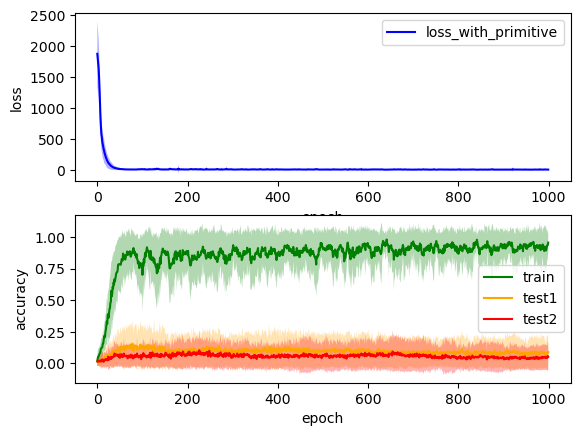

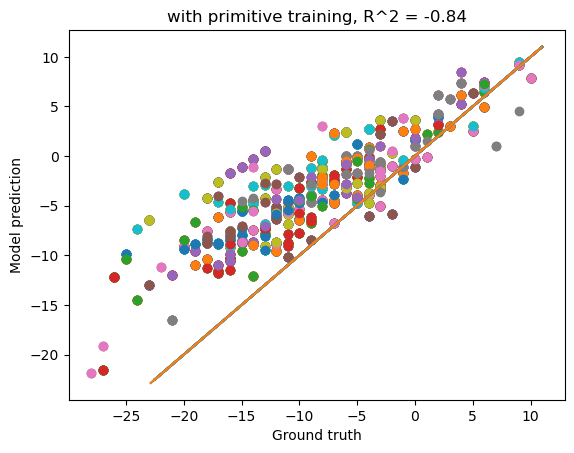

In [29]:
num_layers = 2
hidden_size = 10
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

In [30]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a = 0.1, mode='fan_in')


time:  6.401761182149252
                           label       pred  acc
trial                                           
['B', '-', 'A', '-', 'B']  -12.0  -1.038405  0.0
['B', '-', 'B', '-', 'A']  -12.0  -1.151282  0.0
['C', '-', 'A', '-', 'D']  -10.0   0.798384  0.0
['D', '-', 'A', '-', 'E']  -15.0  -4.591029  0.0
['D', '-', 'A', '-', 'G']   -4.0   6.774237  0.0
['D', '-', 'B', '-', 'A']  -11.0  -0.248067  0.0
['E', '-', 'A', '-', 'G']   -1.0  10.162025  0.0
['E', '-', 'D', '-', 'A']   -9.0   2.037950  0.0
['G', '-', 'B', '-', 'A']  -19.0  -8.159534  0.0
                           label      pred  acc
trial                                          
['B', '-', 'B', '-', 'A']  -10.0 -4.612287  0.5
['D', '-', 'B', '-', 'A']   -5.5 -0.220327  0.5
['B', '-', 'A', '-', 'B']  -10.0 -3.433404  0.0
['C', '-', 'A', '-', 'D']   -8.5 -2.192947  0.0
['D', '-', 'A', '-', 'E']  -14.5 -8.092602  0.0
['D', '-', 'A', '-', 'G']   -7.0 -0.466542  0.0
['E', '-', 'A', '-', 'G']   -2.5  4.562165  0.0
['E'

                               label      pred       acc
trial                                                   
['B', '-', 'B', '-', 'A'] -11.529412 -5.518857  0.176471
['D', '-', 'B', '-', 'A']  -9.529412 -3.800083  0.117647
['D', '-', 'A', '-', 'G'] -10.647059 -4.360149  0.058824
['B', '-', 'A', '-', 'B'] -11.529412 -5.718704  0.000000
['C', '-', 'A', '-', 'D'] -10.294118 -3.944637  0.000000
['D', '-', 'A', '-', 'E'] -11.176471 -5.201135  0.000000
['E', '-', 'A', '-', 'G'] -11.000000 -4.780557  0.000000
['E', '-', 'D', '-', 'A'] -11.882353 -5.714882  0.000000
['G', '-', 'B', '-', 'A'] -10.411765 -4.360480  0.000000
                               label      pred       acc
trial                                                   
['B', '-', 'B', '-', 'A'] -11.555556 -5.652454  0.166667
['D', '-', 'B', '-', 'A']  -9.777778 -4.070898  0.111111
['D', '-', 'A', '-', 'G'] -10.888889 -4.730176  0.055556
['B', '-', 'A', '-', 'B'] -11.555556 -5.849513  0.000000
['C', '-', 'A', '-', 'D'] -10.0

label      pred      acc
trial                                                 
['B', '-', 'B', '-', 'A'] -10.71875 -6.726753  0.15625
['D', '-', 'B', '-', 'A']  -9.25000 -5.667557  0.09375
['B', '-', 'A', '-', 'B'] -10.71875 -6.524062  0.06250
['D', '-', 'A', '-', 'G'] -11.46875 -6.500922  0.06250
['G', '-', 'B', '-', 'A']  -8.50000 -4.963507  0.06250
['E', '-', 'D', '-', 'A']  -9.25000 -4.376818  0.03125
['C', '-', 'A', '-', 'D']  -8.71875 -4.115883  0.00000
['D', '-', 'A', '-', 'E'] -12.18750 -7.351403  0.00000
['E', '-', 'A', '-', 'G'] -10.00000 -5.414697  0.00000

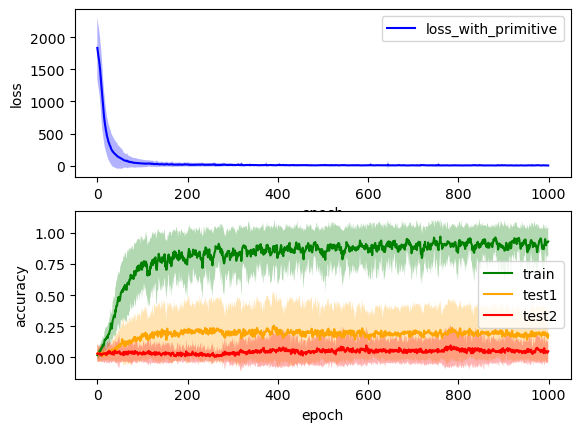

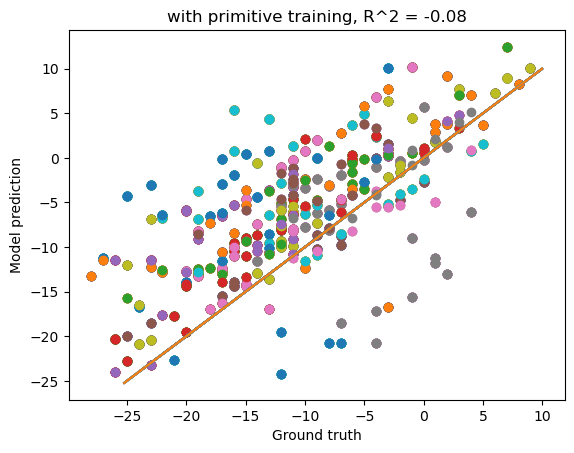

In [31]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

In [32]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a = 0.1, mode='fan_out')


time:  5.4843908508618675
                           label       pred  acc
trial                                           
['B', '-', 'A', '-', 'B']  -17.0  -2.176702  0.0
['B', '-', 'B', '-', 'A']  -17.0  -5.161247  0.0
['C', '-', 'A', '-', 'D']  -12.0  -0.934873  0.0
['D', '-', 'A', '-', 'E']  -27.0 -12.822021  0.0
['D', '-', 'A', '-', 'G']  -15.0  -1.636057  0.0
['D', '-', 'B', '-', 'A']  -29.0 -17.313499  0.0
['E', '-', 'A', '-', 'G']   -5.0   9.611491  0.0
['E', '-', 'D', '-', 'A']   -7.0   6.136199  0.0
['G', '-', 'B', '-', 'A']  -31.0 -19.605881  0.0
                           label      pred  acc
trial                                          
['B', '-', 'A', '-', 'B']  -14.0 -3.694239  0.0
['B', '-', 'B', '-', 'A']  -14.0 -4.595302  0.0
['C', '-', 'A', '-', 'D']  -15.5 -6.493021  0.0
['D', '-', 'A', '-', 'E']  -14.0 -4.049784  0.0
['D', '-', 'A', '-', 'G']  -12.0 -2.294999  0.0
['D', '-', 'B', '-', 'A']  -15.5 -6.162133  0.0
['E', '-', 'A', '-', 'G']  -12.0 -0.464275  0.0
['E

                               label      pred       acc
trial                                                   
['D', '-', 'B', '-', 'A'] -12.222222 -6.891785  0.111111
['B', '-', 'B', '-', 'A'] -11.388889 -5.313996  0.055556
['E', '-', 'A', '-', 'G'] -10.555556 -1.823782  0.055556
['E', '-', 'D', '-', 'A'] -10.111111 -2.965183  0.055556
['G', '-', 'B', '-', 'A'] -11.777778 -5.679094  0.055556
['B', '-', 'A', '-', 'B'] -11.388889 -4.157395  0.000000
['C', '-', 'A', '-', 'D'] -10.944444 -0.614839  0.000000
['D', '-', 'A', '-', 'E'] -12.666667 -1.546090  0.000000
['D', '-', 'A', '-', 'G'] -11.833333 -2.968560  0.000000
                               label      pred       acc
trial                                                   
['D', '-', 'B', '-', 'A'] -12.368421 -7.018373  0.105263
['B', '-', 'B', '-', 'A'] -11.052632 -4.756199  0.052632
['E', '-', 'A', '-', 'G']  -9.684211 -1.381363  0.052632
['E', '-', 'D', '-', 'A']  -9.421053 -2.320340  0.052632
['G', '-', 'B', '-', 'A'] -12.1

label      pred      acc
trial                                                 
['D', '-', 'B', '-', 'A'] -11.34375 -7.318081  0.09375
['E', '-', 'A', '-', 'G']  -9.28125 -4.242932  0.06250
['E', '-', 'D', '-', 'A']  -8.31250 -3.585271  0.06250
['G', '-', 'B', '-', 'A'] -10.37500 -5.134450  0.06250
['B', '-', 'B', '-', 'A']  -9.65625 -4.603348  0.03125
['C', '-', 'A', '-', 'D']  -9.03125 -2.685463  0.03125
['B', '-', 'A', '-', 'B']  -9.65625 -5.198763  0.00000
['D', '-', 'A', '-', 'E'] -11.00000 -4.346945  0.00000
['D', '-', 'A', '-', 'G'] -10.62500 -5.185189  0.00000

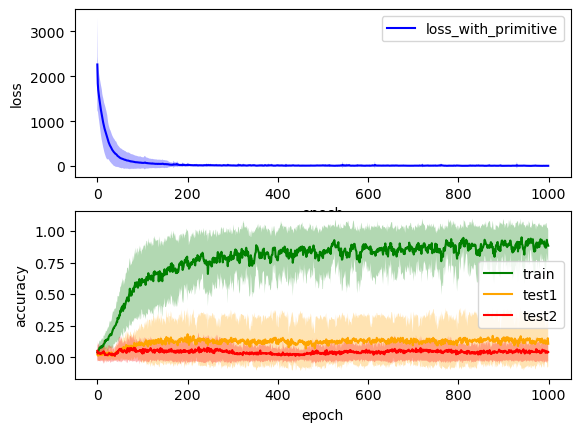

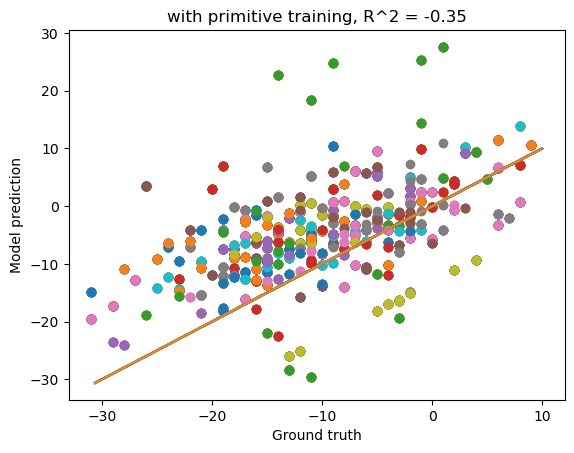

In [33]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

In [40]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a = 0.01, mode='fan_in')


time:  5.408911148707072
                           label       pred  acc
trial                                           
['B', '-', 'A', '-', 'B']   -6.0  -5.663454  1.0
['D', '-', 'A', '-', 'E']    3.0   2.786024  1.0
['D', '-', 'A', '-', 'G']    1.0   0.763780  1.0
['E', '-', 'A', '-', 'G']   -8.0  -7.910718  1.0
['B', '-', 'B', '-', 'A']   -6.0  -6.946570  0.0
['C', '-', 'A', '-', 'D']   -7.0  -7.582724  0.0
['D', '-', 'B', '-', 'A']    0.0  -1.059347  0.0
['E', '-', 'D', '-', 'A']  -15.0 -12.548173  0.0
['G', '-', 'B', '-', 'A']   -7.0  -7.635949  0.0
                           label      pred  acc
trial                                          
['B', '-', 'A', '-', 'B']   -8.0 -4.074114  0.5
['D', '-', 'A', '-', 'E']   -3.0 -0.965015  0.5
['D', '-', 'A', '-', 'G']   -3.5 -0.634784  0.5
['E', '-', 'A', '-', 'G']   -8.5 -5.305978  0.5
['B', '-', 'B', '-', 'A']   -8.0 -5.913465  0.0
['C', '-', 'A', '-', 'D']   -7.0 -4.371412  0.0
['D', '-', 'B', '-', 'A']   -6.0 -3.648916  0.0
['E'

                               label      pred       acc
trial                                                   
['D', '-', 'B', '-', 'A']  -8.285714 -5.063409  0.190476
['D', '-', 'A', '-', 'G'] -11.428571 -7.637459  0.142857
['B', '-', 'A', '-', 'B']  -9.761905 -5.908706  0.047619
['B', '-', 'B', '-', 'A']  -9.761905 -6.139564  0.047619
['D', '-', 'A', '-', 'E'] -10.571429 -6.961809  0.047619
['E', '-', 'A', '-', 'G'] -10.619048 -6.254395  0.047619
['G', '-', 'B', '-', 'A']  -6.619048 -3.866324  0.047619
['C', '-', 'A', '-', 'D']  -7.333333 -3.478445  0.000000
['E', '-', 'D', '-', 'A']  -8.952381 -5.222547  0.000000
                               label      pred       acc
trial                                                   
['D', '-', 'B', '-', 'A']  -7.681818 -4.923840  0.181818
['D', '-', 'A', '-', 'G'] -10.772727 -7.741852  0.136364
['B', '-', 'A', '-', 'B']  -9.409091 -6.485697  0.045455
['B', '-', 'B', '-', 'A']  -9.409091 -6.821802  0.045455
['D', '-', 'A', '-', 'E'] -10.3

label      pred      acc
trial                                                 
['D', '-', 'A', '-', 'E']  -9.50000 -6.449017  0.12500
['D', '-', 'A', '-', 'G'] -10.53125 -7.134156  0.12500
['D', '-', 'B', '-', 'A']  -8.12500 -4.942596  0.12500
['B', '-', 'A', '-', 'B']  -8.93750 -5.476298  0.09375
['E', '-', 'A', '-', 'G']  -9.96875 -6.128439  0.09375
['B', '-', 'B', '-', 'A']  -8.93750 -5.964583  0.06250
['C', '-', 'A', '-', 'D']  -7.53125 -4.105694  0.06250
['E', '-', 'D', '-', 'A']  -8.37500 -4.356693  0.03125
['G', '-', 'B', '-', 'A']  -6.53125 -4.282599  0.03125

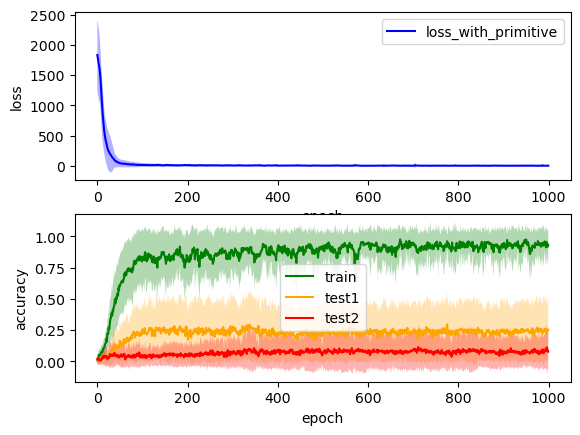

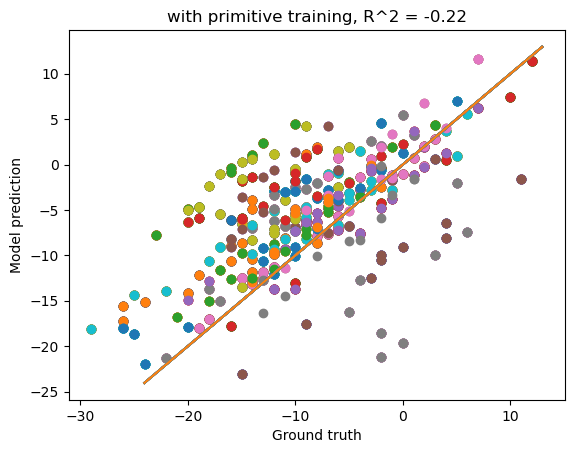

In [41]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

# Kaiming normal

In [36]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a = 0.1)


time:  5.063031919797262
                           label       pred  acc
trial                                           
['B', '-', 'A', '-', 'B']  -16.0 -13.771297  0.0
['B', '-', 'B', '-', 'A']  -16.0 -11.327735  0.0
['C', '-', 'A', '-', 'D']  -11.0   1.086740  0.0
['D', '-', 'A', '-', 'E']  -14.0   0.328029  0.0
['D', '-', 'A', '-', 'G']  -13.0   1.288204  0.0
['D', '-', 'B', '-', 'A']  -12.0  -2.610723  0.0
['E', '-', 'A', '-', 'G']  -15.0  -5.243010  0.0
['E', '-', 'D', '-', 'A']  -18.0  -9.219629  0.0
['G', '-', 'B', '-', 'A']  -15.0 -10.661254  0.0
                           label       pred  acc
trial                                           
['C', '-', 'A', '-', 'D']  -11.0  -4.778722  0.5
['B', '-', 'A', '-', 'B']   -9.5  -9.578765  0.0
['B', '-', 'B', '-', 'A']   -9.5  -6.152924  0.0
['D', '-', 'A', '-', 'E']   -2.0   3.014992  0.0
['D', '-', 'A', '-', 'G']   -5.0   0.342959  0.0
['D', '-', 'B', '-', 'A']   -5.5  -0.371220  0.0
['E', '-', 'A', '-', 'G']  -12.5 -10.155886 

                           label      pred   acc
trial                                           
['E', '-', 'D', '-', 'A']  -8.05 -3.487934  0.15
['C', '-', 'A', '-', 'D'] -10.35 -4.843825  0.10
['D', '-', 'A', '-', 'G'] -10.15 -5.210848  0.10
['D', '-', 'B', '-', 'A'] -10.90 -5.709508  0.10
['B', '-', 'A', '-', 'B'] -10.30 -5.349247  0.05
['B', '-', 'B', '-', 'A'] -10.30 -5.421794  0.05
['D', '-', 'A', '-', 'E'] -12.55 -6.796424  0.05
['E', '-', 'A', '-', 'G']  -7.90 -3.590053  0.05
['G', '-', 'B', '-', 'A'] -11.05 -5.576138  0.05
                               label      pred       acc
trial                                                   
['E', '-', 'D', '-', 'A']  -8.000000 -3.370169  0.142857
['C', '-', 'A', '-', 'D'] -10.380952 -4.984450  0.095238
['D', '-', 'A', '-', 'G']  -9.952381 -5.109489  0.095238
['D', '-', 'B', '-', 'A'] -10.714286 -5.651356  0.095238
['B', '-', 'A', '-', 'B'] -10.047619 -5.222346  0.047619
['B', '-', 'B', '-', 'A'] -10.047619 -5.321760  0.047619
['D',

label      pred      acc
trial                                                 
['E', '-', 'D', '-', 'A']  -8.96875 -4.908851  0.12500
['D', '-', 'A', '-', 'E']  -9.96875 -5.820010  0.09375
['D', '-', 'A', '-', 'G']  -7.90625 -4.556333  0.09375
['C', '-', 'A', '-', 'D'] -10.96875 -7.073347  0.06250
['D', '-', 'B', '-', 'A']  -8.31250 -4.553387  0.06250
['E', '-', 'A', '-', 'G']  -7.40625 -4.409068  0.06250
['B', '-', 'A', '-', 'B']  -9.46875 -5.719342  0.03125
['B', '-', 'B', '-', 'A']  -9.46875 -5.830441  0.03125
['G', '-', 'B', '-', 'A']  -9.87500 -5.638402  0.03125

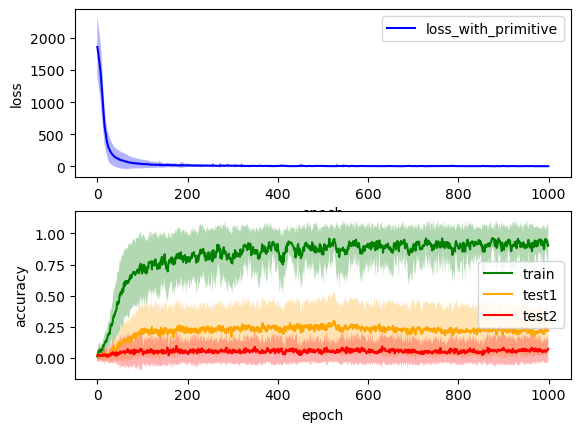

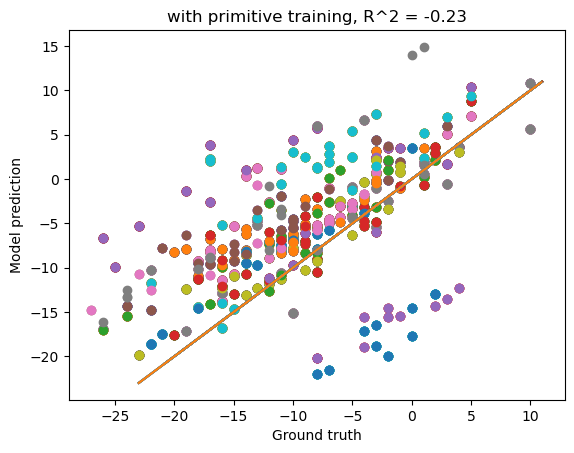

In [37]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

In [42]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a = 0.01)


time:  5.507273848851522
                           label      pred  acc
trial                                          
['B', '-', 'A', '-', 'B']  -15.0  2.461667  0.0
['B', '-', 'B', '-', 'A']  -15.0 -1.595345  0.0
['C', '-', 'A', '-', 'D']   -9.0  8.467009  0.0
['D', '-', 'A', '-', 'E']  -18.0 -0.977486  0.0
['D', '-', 'A', '-', 'G']  -12.0  3.897314  0.0
['D', '-', 'B', '-', 'A']  -16.0 -3.001010  0.0
['E', '-', 'A', '-', 'G']   -9.0  7.817066  0.0
['E', '-', 'D', '-', 'A']  -12.0  2.993832  0.0
['G', '-', 'B', '-', 'A']  -19.0 -4.984342  0.0
                           label      pred  acc
trial                                          
['B', '-', 'A', '-', 'B']  -14.0 -1.723441  0.0
['B', '-', 'B', '-', 'A']  -14.0 -3.597026  0.0
['C', '-', 'A', '-', 'D']   -9.5  2.221033  0.0
['D', '-', 'A', '-', 'E']  -14.5 -0.656537  0.0
['D', '-', 'A', '-', 'G']  -13.0  0.145195  0.0
['D', '-', 'B', '-', 'A']   -9.0 -0.890913  0.0
['E', '-', 'A', '-', 'G']  -12.5  1.721752  0.0
['E', '-', 'D',

                               label      pred       acc
trial                                                   
['D', '-', 'B', '-', 'A']  -7.714286 -4.528795  0.190476
['B', '-', 'A', '-', 'B']  -9.523810 -3.642657  0.142857
['G', '-', 'B', '-', 'A']  -7.523810 -3.847549  0.142857
['B', '-', 'B', '-', 'A']  -9.523810 -5.009660  0.047619
['C', '-', 'A', '-', 'D'] -10.571429 -4.425654  0.047619
['D', '-', 'A', '-', 'E']  -9.714286 -4.425528  0.047619
['E', '-', 'A', '-', 'G']  -9.523810 -4.265952  0.047619
['E', '-', 'D', '-', 'A']  -9.333333 -4.433258  0.047619
['D', '-', 'A', '-', 'G']  -9.714286 -4.587628  0.000000
                               label      pred       acc
trial                                                   
['D', '-', 'B', '-', 'A']  -7.636364 -4.387681  0.181818
['B', '-', 'A', '-', 'B']  -9.636364 -3.862493  0.136364
['G', '-', 'B', '-', 'A']  -7.772727 -3.943270  0.136364
['D', '-', 'A', '-', 'E']  -9.590909 -4.550272  0.090909
['B', '-', 'B', '-', 'A']  -9.6

label      pred      acc
trial                                                 
['B', '-', 'A', '-', 'B']  -8.96875 -4.435905  0.12500
['D', '-', 'B', '-', 'A']  -6.93750 -4.153131  0.12500
['G', '-', 'B', '-', 'A']  -7.71875 -4.342726  0.12500
['D', '-', 'A', '-', 'G']  -8.18750 -4.724827  0.09375
['D', '-', 'A', '-', 'E']  -9.00000 -5.305880  0.06250
['B', '-', 'B', '-', 'A']  -8.96875 -5.064620  0.03125
['C', '-', 'A', '-', 'D'] -10.25000 -5.622865  0.03125
['E', '-', 'A', '-', 'G']  -8.15625 -4.480419  0.03125
['E', '-', 'D', '-', 'A']  -8.93750 -5.040165  0.03125

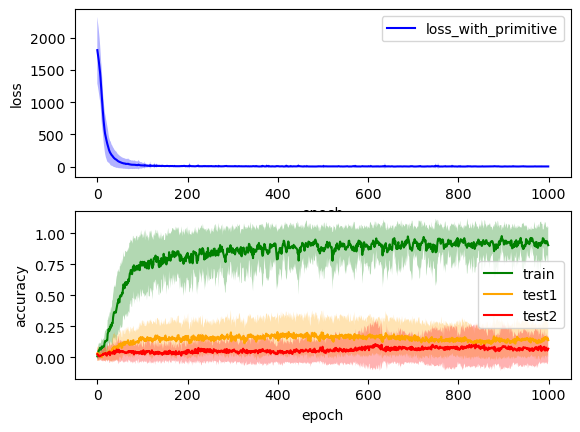

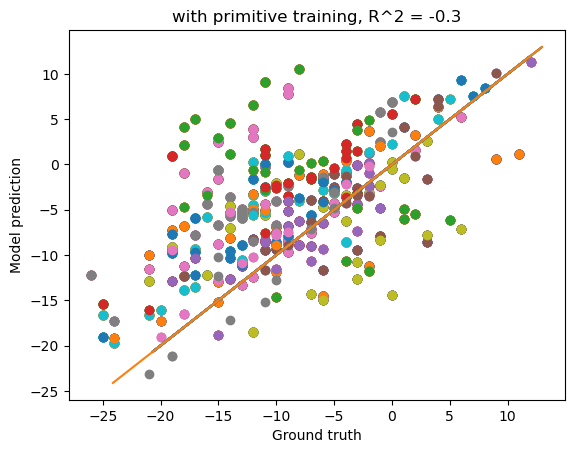

In [43]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

In [44]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a = 0.001)


time:  5.529430449008942
                           label       pred  acc
trial                                           
['B', '-', 'A', '-', 'B']   -5.0  -5.099678  1.0
['B', '-', 'B', '-', 'A']   -5.0   0.600059  0.0
['C', '-', 'A', '-', 'D']   -6.0 -10.972057  0.0
['D', '-', 'A', '-', 'E']   -2.0  -6.334141  0.0
['D', '-', 'A', '-', 'G']    6.0   1.645695  0.0
['D', '-', 'B', '-', 'A']   -3.0  -0.384481  0.0
['E', '-', 'A', '-', 'G']    3.0  -1.628611  0.0
['E', '-', 'D', '-', 'A']   -8.0  -9.534084  0.0
['G', '-', 'B', '-', 'A']  -14.0 -11.796070  0.0
                           label       pred  acc
trial                                           
['B', '-', 'A', '-', 'B']  -11.0  -8.631199  0.5
['B', '-', 'B', '-', 'A']  -11.0  -4.310834  0.0
['C', '-', 'A', '-', 'D']  -14.0 -13.227751  0.0
['D', '-', 'A', '-', 'E']  -11.0 -11.530416  0.0
['D', '-', 'A', '-', 'G']   -6.0  -5.926441  0.0
['D', '-', 'B', '-', 'A']   -8.5  -3.399721  0.0
['E', '-', 'A', '-', 'G']   -6.0  -6.412724 

                               label      pred       acc
trial                                                   
['B', '-', 'B', '-', 'A'] -10.333333 -4.597603  0.095238
['B', '-', 'A', '-', 'B'] -10.333333 -6.718986  0.047619
['D', '-', 'A', '-', 'E'] -11.714286 -8.204381  0.047619
['D', '-', 'A', '-', 'G'] -12.095238 -8.703623  0.047619
['D', '-', 'B', '-', 'A'] -11.619048 -6.199087  0.047619
['G', '-', 'B', '-', 'A']  -9.857143 -4.961469  0.047619
['C', '-', 'A', '-', 'D']  -9.380952 -6.979121  0.000000
['E', '-', 'A', '-', 'G'] -10.714286 -6.905037  0.000000
['E', '-', 'D', '-', 'A']  -8.952381 -4.507205  0.000000
                               label      pred       acc
trial                                                   
['B', '-', 'B', '-', 'A'] -10.136364 -4.547252  0.090909
['B', '-', 'A', '-', 'B'] -10.136364 -6.482090  0.045455
['D', '-', 'A', '-', 'E'] -11.090909 -7.640209  0.045455
['D', '-', 'A', '-', 'G'] -11.727273 -8.385450  0.045455
['D', '-', 'B', '-', 'A'] -11.3

label      pred      acc
trial                                                 
['B', '-', 'B', '-', 'A'] -10.68750 -5.210162  0.09375
['C', '-', 'A', '-', 'D'] -10.09375 -6.842813  0.06250
['D', '-', 'A', '-', 'G'] -11.34375 -7.194598  0.06250
['B', '-', 'A', '-', 'B'] -10.68750 -6.903935  0.03125
['D', '-', 'A', '-', 'E'] -10.50000 -6.599759  0.03125
['D', '-', 'B', '-', 'A'] -11.25000 -6.589341  0.03125
['G', '-', 'B', '-', 'A'] -10.59375 -5.829065  0.03125
['E', '-', 'A', '-', 'G'] -11.53125 -6.760330  0.00000
['E', '-', 'D', '-', 'A'] -10.87500 -6.129413  0.00000

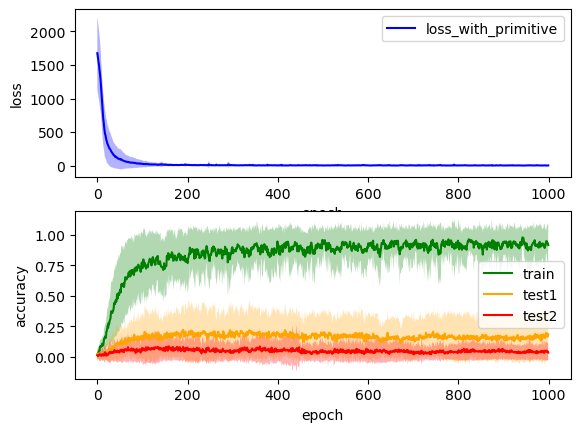

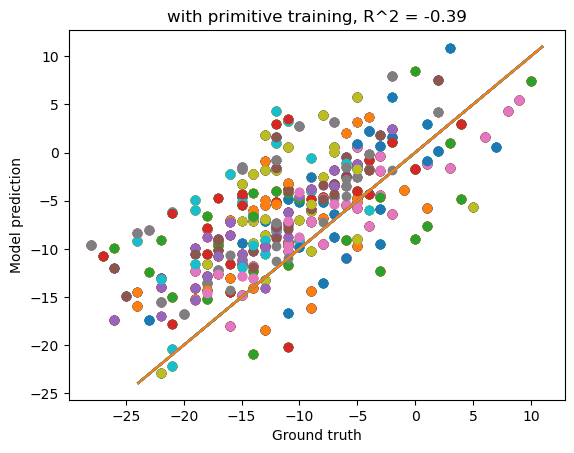

In [45]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

# Xavier Normal

In [48]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.1)


time:  4.90483961502711
                           label       pred  acc
trial                                           
['B', '-', 'A', '-', 'B']  -12.0  -8.505769  0.0
['B', '-', 'B', '-', 'A']  -12.0  -9.257935  0.0
['C', '-', 'A', '-', 'D']  -10.0  -7.473101  0.0
['D', '-', 'A', '-', 'E']  -15.0 -10.991061  0.0
['D', '-', 'A', '-', 'G']  -25.0 -16.071011  0.0
['D', '-', 'B', '-', 'A']  -18.0 -14.440785  0.0
['E', '-', 'A', '-', 'G']  -22.0 -13.192451  0.0
['E', '-', 'D', '-', 'A']   -9.0  -5.332872  0.0
['G', '-', 'B', '-', 'A']   -5.0  -0.332059  0.0
                           label       pred  acc
trial                                           
['B', '-', 'B', '-', 'A']   -9.0  -7.659248  0.5
['D', '-', 'B', '-', 'A']  -15.0 -13.228906  0.5
['E', '-', 'D', '-', 'A']   -1.0   0.936152  0.5
['G', '-', 'B', '-', 'A']   -3.5  -0.917777  0.5
['B', '-', 'A', '-', 'B']   -9.0  -6.318144  0.0
['C', '-', 'A', '-', 'D']   -2.0   0.318295  0.0
['D', '-', 'A', '-', 'E']  -17.0 -13.988353  

                               label      pred       acc
trial                                                   
['D', '-', 'A', '-', 'G'] -10.947368 -6.317086  0.105263
['B', '-', 'B', '-', 'A'] -10.157895 -4.911098  0.052632
['D', '-', 'B', '-', 'A'] -10.736842 -7.784772  0.052632
['E', '-', 'A', '-', 'G'] -10.157895 -4.849488  0.052632
['E', '-', 'D', '-', 'A']  -9.368421 -5.303956  0.052632
['G', '-', 'B', '-', 'A']  -9.947368 -5.345556  0.052632
['B', '-', 'A', '-', 'B'] -10.157895 -4.677603  0.000000
['C', '-', 'A', '-', 'D'] -10.473684 -4.589327  0.000000
['D', '-', 'A', '-', 'E'] -10.947368 -6.855689  0.000000
                           label      pred   acc
trial                                           
['D', '-', 'A', '-', 'G'] -11.05 -6.358900  0.10
['B', '-', 'B', '-', 'A'] -10.15 -4.949547  0.05
['D', '-', 'B', '-', 'A'] -11.05 -8.060503  0.05
['E', '-', 'A', '-', 'G']  -9.85 -4.540653  0.05
['E', '-', 'D', '-', 'A']  -8.95 -4.934119  0.05
['G', '-', 'B', '-', 'A'] -10.

label      pred      acc
trial                                                
['E', '-', 'D', '-', 'A']  -9.8125 -5.208674  0.09375
['D', '-', 'A', '-', 'G'] -10.3125 -5.287895  0.06250
['D', '-', 'B', '-', 'A'] -10.1250 -6.354553  0.06250
['G', '-', 'B', '-', 'A'] -10.1875 -3.968511  0.06250
['B', '-', 'B', '-', 'A'] -10.3750 -4.248224  0.03125
['E', '-', 'A', '-', 'G']  -9.7500 -4.761863  0.03125
['B', '-', 'A', '-', 'B'] -10.3750 -4.120425  0.00000
['C', '-', 'A', '-', 'D'] -10.9375 -4.790532  0.00000
['D', '-', 'A', '-', 'E'] -10.9375 -6.115332  0.00000

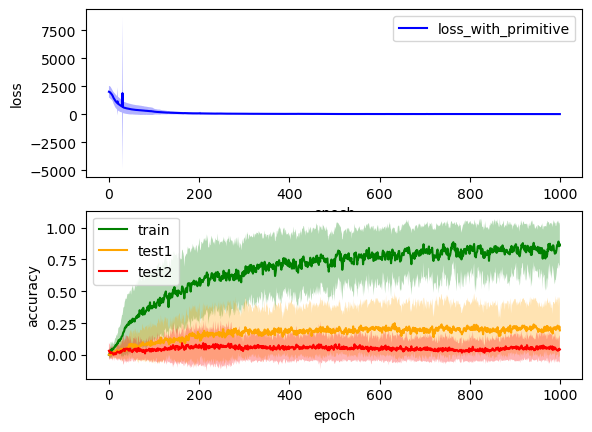

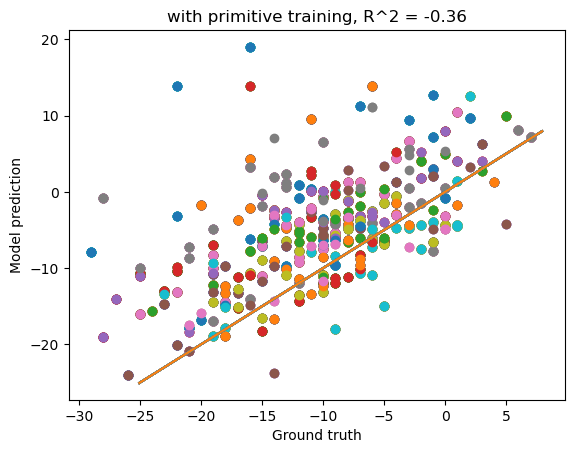

In [49]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

In [52]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.001)


time:  4.877915215492249
                           label      pred  acc
trial                                          
['B', '-', 'A', '-', 'B']  -15.0 -0.906401  0.0
['B', '-', 'B', '-', 'A']  -15.0 -1.556612  0.0
['C', '-', 'A', '-', 'D']  -11.0  3.143608  0.0
['D', '-', 'A', '-', 'E']  -23.0 -5.569766  0.0
['D', '-', 'A', '-', 'G']  -24.0 -9.016167  0.0
['D', '-', 'B', '-', 'A']  -21.0 -6.468471  0.0
['E', '-', 'A', '-', 'G']  -16.0 -1.646969  0.0
['E', '-', 'D', '-', 'A']   -7.0  7.091514  0.0
['G', '-', 'B', '-', 'A']  -12.0  1.522727  0.0
                           label       pred  acc
trial                                           
['C', '-', 'A', '-', 'D']   -9.0  -1.750136  0.5
['D', '-', 'A', '-', 'G']  -18.0 -10.337169  0.5
['B', '-', 'A', '-', 'B']  -13.0  -3.533210  0.0
['B', '-', 'B', '-', 'A']  -13.0  -3.977961  0.0
['D', '-', 'A', '-', 'E']  -21.5 -10.801617  0.0
['D', '-', 'B', '-', 'A']  -19.5  -9.830224  0.0
['E', '-', 'A', '-', 'G']   -9.5  -1.838123  0.0
['E', 

                             label      pred     acc
trial                                               
['D', '-', 'B', '-', 'A'] -11.4375 -8.084777  0.1875
['C', '-', 'A', '-', 'D']  -9.0000 -3.553827  0.1250
['D', '-', 'A', '-', 'G']  -9.9375 -5.856410  0.1250
['B', '-', 'B', '-', 'A']  -8.8125 -5.223261  0.0625
['D', '-', 'A', '-', 'E']  -9.9375 -4.939905  0.0625
['E', '-', 'A', '-', 'G']  -8.8125 -5.158857  0.0625
['E', '-', 'D', '-', 'A']  -7.6875 -2.209582  0.0625
['G', '-', 'B', '-', 'A'] -10.3125 -7.382697  0.0625
['B', '-', 'A', '-', 'B']  -8.8125 -4.408045  0.0000
                               label      pred       acc
trial                                                   
['D', '-', 'B', '-', 'A'] -10.764706 -7.159415  0.176471
['C', '-', 'A', '-', 'D']  -9.117647 -3.281289  0.117647
['D', '-', 'A', '-', 'G']  -9.470588 -5.420443  0.117647
['B', '-', 'B', '-', 'A']  -8.647059 -4.466165  0.058824
['D', '-', 'A', '-', 'E']  -9.294118 -4.208050  0.058824
['E', '-', 'A', '-

                              label      pred      acc
trial                                                 
['D', '-', 'B', '-', 'A']  -9.25000 -5.875761  0.09375
['B', '-', 'A', '-', 'B']  -9.18750 -4.415205  0.06250
['B', '-', 'B', '-', 'A']  -9.18750 -4.306764  0.06250
['C', '-', 'A', '-', 'D']  -9.53125 -4.127382  0.06250
['D', '-', 'A', '-', 'G']  -7.71875 -3.799885  0.06250
['E', '-', 'A', '-', 'G']  -8.18750 -3.894514  0.06250
['E', '-', 'D', '-', 'A']  -9.65625 -3.549740  0.06250
['D', '-', 'A', '-', 'E']  -8.71875 -4.258057  0.03125
['G', '-', 'B', '-', 'A'] -10.71875 -6.354796  0.03125


label      pred      acc
trial                                                 
['D', '-', 'B', '-', 'A']  -9.25000 -5.875761  0.09375
['B', '-', 'A', '-', 'B']  -9.18750 -4.415205  0.06250
['B', '-', 'B', '-', 'A']  -9.18750 -4.306764  0.06250
['C', '-', 'A', '-', 'D']  -9.53125 -4.127382  0.06250
['D', '-', 'A', '-', 'G']  -7.71875 -3.799885  0.06250
['E', '-', 'A', '-', 'G']  -8.18750 -3.894514  0.06250
['E', '-', 'D', '-', 'A']  -9.65625 -3.549740  0.06250
['D', '-', 'A', '-', 'E']  -8.71875 -4.258057  0.03125
['G', '-', 'B', '-', 'A'] -10.71875 -6.354796  0.03125

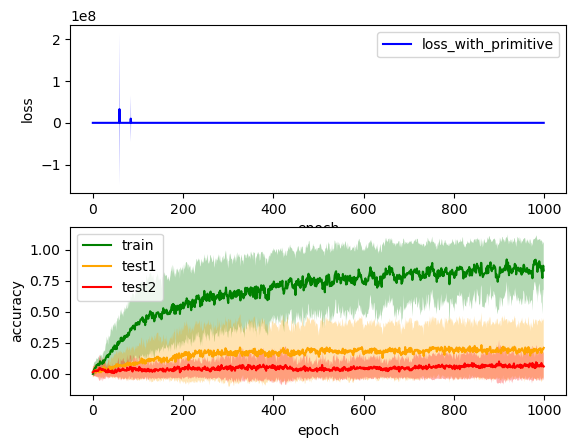

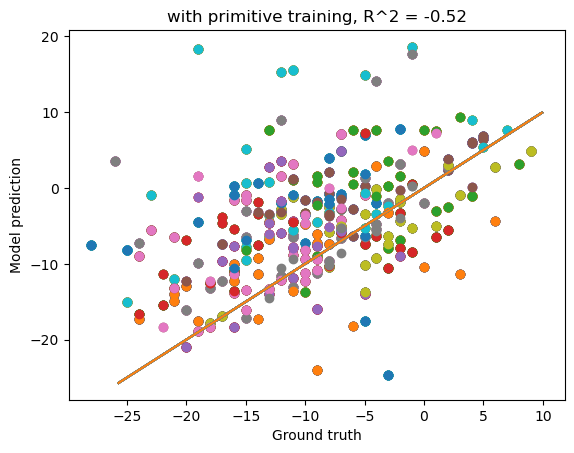

In [53]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

In [56]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.000001)


In [ ]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

# Xavier Uniform

In [50]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, 0.1)


time:  4.760812517007192
                           label       pred  acc
trial                                           
['B', '-', 'A', '-', 'B']  -15.0  -4.779751  0.0
['B', '-', 'B', '-', 'A']  -15.0  -6.192167  0.0
['C', '-', 'A', '-', 'D']  -10.0 -13.707083  0.0
['D', '-', 'A', '-', 'E']  -26.0 -19.058460  0.0
['D', '-', 'A', '-', 'G']  -22.0 -19.023312  0.0
['D', '-', 'B', '-', 'A']  -27.0 -20.748438  0.0
['E', '-', 'A', '-', 'G']  -11.0  -5.196713  0.0
['E', '-', 'D', '-', 'A']   -4.0  -5.569318  0.0
['G', '-', 'B', '-', 'A']  -20.0 -11.191803  0.0
                           label       pred  acc
trial                                           
['B', '-', 'A', '-', 'B']  -11.0  -5.756254  0.5
['B', '-', 'B', '-', 'A']  -11.0  -6.776355  0.5
['C', '-', 'A', '-', 'D']   -8.0  -9.718616  0.5
['D', '-', 'A', '-', 'E']  -14.0 -10.413782  0.5
['D', '-', 'A', '-', 'G']  -12.5 -10.881591  0.5
['D', '-', 'B', '-', 'A']  -13.0 -10.043289  0.5
['E', '-', 'A', '-', 'G']   -9.5  -6.473175 

                               label      pred       acc
trial                                                   
['B', '-', 'B', '-', 'A']  -9.578947 -5.380487  0.157895
['G', '-', 'B', '-', 'A']  -7.631579 -4.390082  0.157895
['B', '-', 'A', '-', 'B']  -9.578947 -5.381533  0.105263
['C', '-', 'A', '-', 'D']  -8.368421 -5.185145  0.105263
['D', '-', 'A', '-', 'E'] -11.263158 -7.036251  0.105263
['D', '-', 'B', '-', 'A']  -9.894737 -7.137552  0.105263
['E', '-', 'A', '-', 'G'] -10.157895 -6.805703  0.105263
['E', '-', 'D', '-', 'A']  -7.894737 -5.650378  0.105263
['D', '-', 'A', '-', 'G'] -11.842105 -8.025542  0.052632
                           label      pred   acc
trial                                           
['B', '-', 'B', '-', 'A']  -9.90 -5.383133  0.15
['D', '-', 'A', '-', 'E'] -11.70 -7.703159  0.15
['G', '-', 'B', '-', 'A']  -8.10 -4.411825  0.15
['B', '-', 'A', '-', 'B']  -9.90 -6.207790  0.10
['C', '-', 'A', '-', 'D']  -8.95 -6.054357  0.10
['D', '-', 'B', '-', 'A'] -10.

label      pred      acc
trial                                                
['G', '-', 'B', '-', 'A']  -9.0625 -4.419894  0.15625
['B', '-', 'B', '-', 'A']  -9.8125 -4.719091  0.12500
['D', '-', 'B', '-', 'A']  -9.3750 -5.452245  0.12500
['D', '-', 'A', '-', 'E'] -10.4375 -5.656817  0.09375
['E', '-', 'A', '-', 'G']  -9.5000 -5.431438  0.09375
['B', '-', 'A', '-', 'B']  -9.8125 -5.294429  0.06250
['C', '-', 'A', '-', 'D']  -9.3750 -5.820725  0.06250
['D', '-', 'A', '-', 'G'] -10.1250 -5.971205  0.06250
['E', '-', 'D', '-', 'A']  -9.1875 -3.969019  0.06250

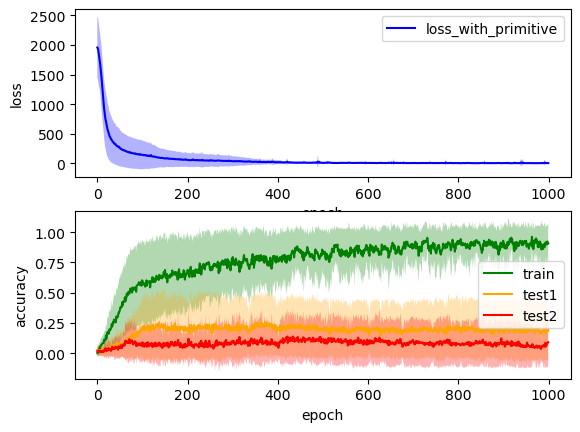

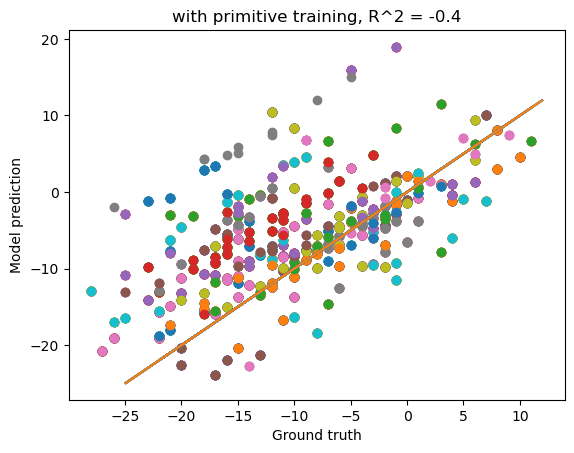

In [51]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

In [54]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))


time:  4.7672106663386025
                           label       pred  acc
trial                                           
['B', '-', 'A', '-', 'B']  -12.0  -3.880292  0.0
['B', '-', 'B', '-', 'A']  -12.0  -3.976404  0.0
['C', '-', 'A', '-', 'D']   -2.0   0.171481  0.0
['D', '-', 'A', '-', 'E']  -11.0  -4.771383  0.0
['D', '-', 'A', '-', 'G']  -20.0 -10.715580  0.0
['D', '-', 'B', '-', 'A']  -14.0  -6.590423  0.0
['E', '-', 'A', '-', 'G']  -21.0 -11.793843  0.0
['E', '-', 'D', '-', 'A']  -13.0  -7.226867  0.0
['G', '-', 'B', '-', 'A']   -6.0   0.304093  0.0
                           label      pred  acc
trial                                          
['B', '-', 'A', '-', 'B']  -14.5 -2.448883  0.0
['B', '-', 'B', '-', 'A']  -14.5 -2.420602  0.0
['C', '-', 'A', '-', 'D']  -11.5 -3.424837  0.0
['D', '-', 'A', '-', 'E']  -13.0 -1.827248  0.0
['D', '-', 'A', '-', 'G']  -17.0 -4.584569  0.0
['D', '-', 'B', '-', 'A']  -15.0 -4.390577  0.0
['E', '-', 'A', '-', 'G']  -18.5 -6.621794  0.0
['E

                              label      pred       acc
trial                                                  
['E', '-', 'D', '-', 'A'] -9.157895 -4.107107  0.105263
['B', '-', 'A', '-', 'B'] -9.421053 -4.839533  0.052632
['C', '-', 'A', '-', 'D'] -9.736842 -5.848308  0.052632
['E', '-', 'A', '-', 'G'] -9.157895 -4.922096  0.052632
['G', '-', 'B', '-', 'A'] -8.684211 -2.802301  0.052632
['B', '-', 'B', '-', 'A'] -9.421053 -3.673700  0.000000
['D', '-', 'A', '-', 'E'] -9.684211 -4.923093  0.000000
['D', '-', 'A', '-', 'G'] -9.421053 -4.275542  0.000000
['D', '-', 'B', '-', 'A'] -8.684211 -3.702740  0.000000
                           label      pred   acc
trial                                           
['E', '-', 'A', '-', 'G']  -9.15 -5.115464  0.10
['E', '-', 'D', '-', 'A']  -8.90 -4.215255  0.10
['G', '-', 'B', '-', 'A']  -8.85 -3.251611  0.10
['B', '-', 'A', '-', 'B']  -9.65 -5.126311  0.05
['C', '-', 'A', '-', 'D']  -9.50 -5.873749  0.05
['B', '-', 'B', '-', 'A']  -9.65 -4.15861

label      pred      acc
trial                                                 
['E', '-', 'D', '-', 'A']  -8.75000 -4.672758  0.09375
['E', '-', 'A', '-', 'G']  -8.34375 -4.491241  0.06250
['G', '-', 'B', '-', 'A']  -9.31250 -4.153921  0.06250
['B', '-', 'A', '-', 'B']  -9.28125 -4.630323  0.03125
['C', '-', 'A', '-', 'D'] -10.34375 -6.503233  0.03125
['D', '-', 'B', '-', 'A']  -8.90625 -4.293453  0.03125
['B', '-', 'B', '-', 'A']  -9.28125 -4.366961  0.00000
['D', '-', 'A', '-', 'E']  -9.81250 -5.522062  0.00000
['D', '-', 'A', '-', 'G']  -8.87500 -3.827422  0.00000

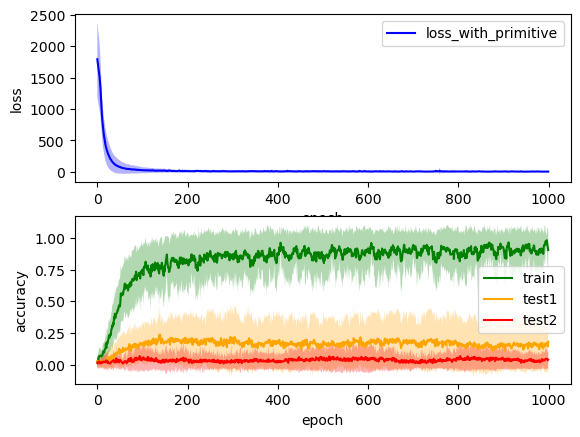

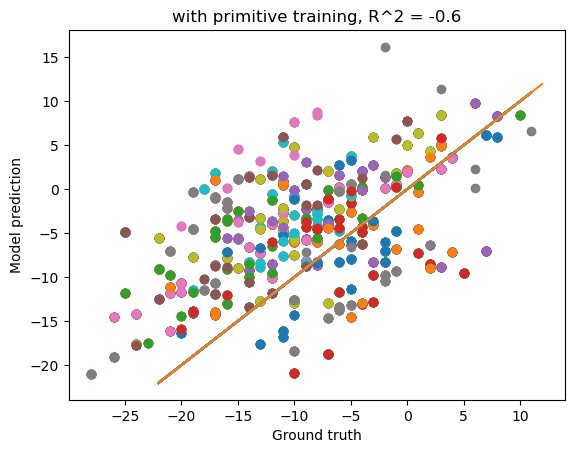

In [55]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

time:  11.238782680034637
                           label       pred  acc
trial                                           
['B', '-', 'A', '-', 'B']  -16.0  -9.327725  0.0
['C', '-', 'A', '-', 'B']  -17.0  -9.977945  0.0
['C', '-', 'F', '-', 'A']  -25.0 -16.569118  0.0
['D', '-', 'A', '-', 'E']  -14.0  -8.125782  0.0
['D', '-', 'C', '-', 'A']   -6.0   0.166484  0.0
['D', '-', 'F', '-', 'A']  -15.0  -5.708441  0.0
['F', '-', 'A', '-', 'C']   -7.0   0.711591  0.0
['F', '-', 'B', '-', 'A']   -8.0  -1.752315  0.0
['F', '-', 'C', '-', 'A']   -7.0  -0.821677  0.0
                           label      pred  acc
trial                                          
['B', '-', 'A', '-', 'B']  -15.0 -7.574422  0.0
['C', '-', 'A', '-', 'B']   -9.0 -1.854003  0.0
['C', '-', 'F', '-', 'A']  -14.0 -5.504207  0.0
['D', '-', 'A', '-', 'E']   -9.5 -0.938544  0.0
['D', '-', 'C', '-', 'A']  -13.0 -6.491947  0.0
['D', '-', 'F', '-', 'A']  -12.0 -2.685712  0.0
['F', '-', 'A', '-', 'C']  -16.0 -4.751143  0.0
['F

label      pred     acc
trial                                               
['B', '-', 'A', '-', 'B'] -10.4375 -7.168182  0.0625
['D', '-', 'A', '-', 'E'] -10.7500 -7.369106  0.0625
['F', '-', 'C', '-', 'A']  -9.0000 -5.794587  0.0625
['C', '-', 'A', '-', 'B'] -11.5000 -7.064572  0.0000
['C', '-', 'F', '-', 'A'] -11.8750 -8.129303  0.0000
['D', '-', 'C', '-', 'A'] -10.3750 -6.806313  0.0000
['D', '-', 'F', '-', 'A'] -11.8125 -7.605552  0.0000
['F', '-', 'A', '-', 'C']  -9.0000 -5.388541  0.0000
['F', '-', 'B', '-', 'A'] -10.0625 -5.398821  0.0000

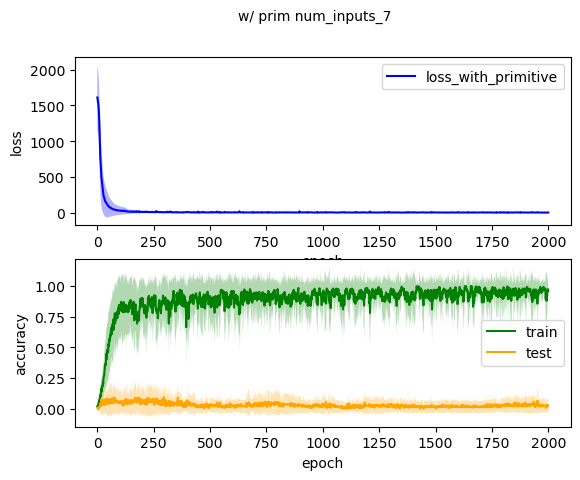

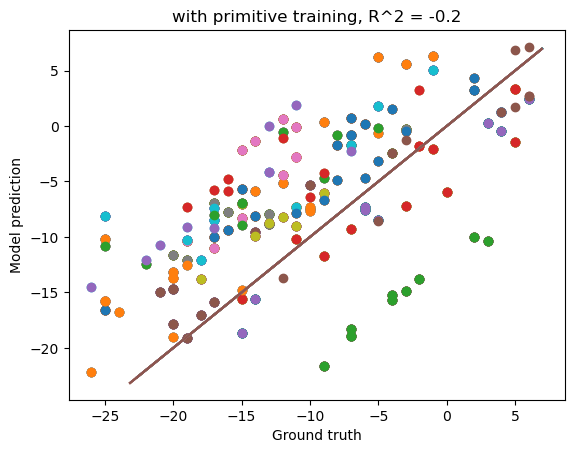

In [111]:
num_layers = 1
hidden_size = 20
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs1, testseqs2) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test1 = np.array([r['acc'][:,1] for r in res]).T
acc_test2 = np.array([r['acc'][:,2] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test1, acc_test2], \
        ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
plt.figure()
predcorr(mods, tests)

In [112]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.leaky_relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        y = 1/math.sqrt(hidden_size)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, 0.001)


time:  10.999074947834014
                           label       pred  acc
trial                                           
['C', '-', 'F', '-', 'A']  -12.0 -12.311895  1.0
['B', '-', 'A', '-', 'B']   -5.0 -10.327076  0.0
['C', '-', 'A', '-', 'B']  -10.0 -13.551843  0.0
['D', '-', 'A', '-', 'E']    4.0  -3.752858  0.0
['D', '-', 'C', '-', 'A']    1.0  -2.161740  0.0
['D', '-', 'F', '-', 'A']   -6.0  -9.022490  0.0
['F', '-', 'A', '-', 'C']    2.0  -5.545892  0.0
['F', '-', 'B', '-', 'A']   -3.0  -7.818477  0.0
['F', '-', 'C', '-', 'A']    2.0  -1.536654  0.0
                           label      pred  acc
trial                                          
['C', '-', 'F', '-', 'A']  -10.5 -8.676389  0.5
['B', '-', 'A', '-', 'B']   -8.5 -6.586608  0.0
['C', '-', 'A', '-', 'B']   -9.0 -5.976848  0.0
['D', '-', 'A', '-', 'E']   -1.5  0.159844  0.0
['D', '-', 'C', '-', 'A']   -2.0 -0.620716  0.0
['D', '-', 'F', '-', 'A']   -4.0 -3.105331  0.0
['F', '-', 'A', '-', 'C']   -6.5 -5.347383  0.0
['F

label      pred     acc
trial                                              
['B', '-', 'A', '-', 'B'] -7.1250 -5.275545  0.0625
['C', '-', 'A', '-', 'B'] -7.1250 -4.343698  0.0625
['C', '-', 'F', '-', 'A'] -8.5625 -5.269958  0.0625
['D', '-', 'F', '-', 'A'] -9.0000 -5.296465  0.0625
['F', '-', 'A', '-', 'C'] -5.6875 -3.221288  0.0625
['F', '-', 'B', '-', 'A'] -5.6875 -3.128401  0.0625
['F', '-', 'C', '-', 'A'] -5.6875 -2.715140  0.0625
['D', '-', 'A', '-', 'E'] -6.3125 -3.840786  0.0000
['D', '-', 'C', '-', 'A'] -7.5625 -5.102499  0.0000

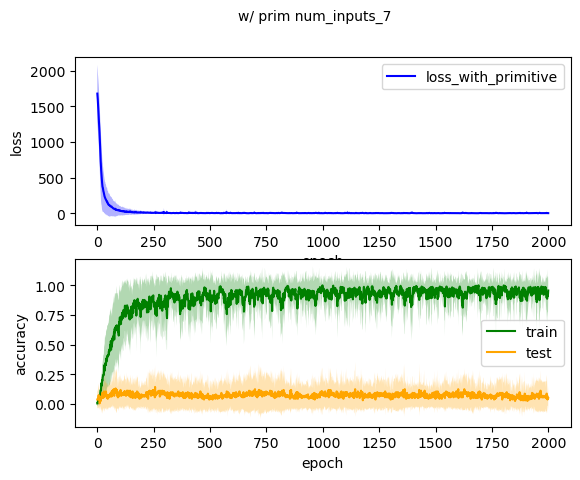

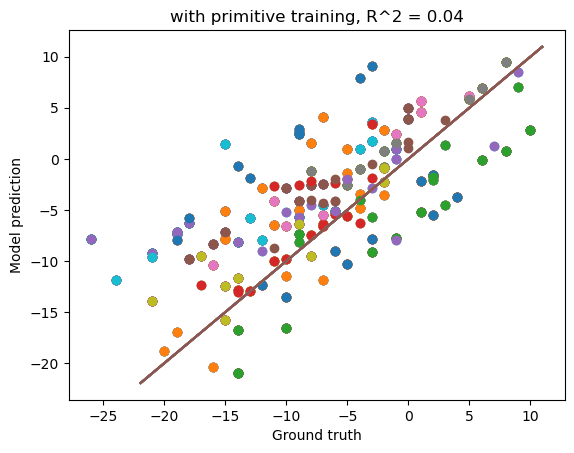

In [113]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [90]:
ops = ['+']
p = pad_seqs_1step(all_syms, cue_dict, padder = ('+', 'X'))
trainseqs = pad_seqs_2step(generate_other_1step(ops, all_syms[1:], all_syms[1:]), padder = ('+', 'X')) + p
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

time:  7.752503983179728
                           label       pred  acc
trial                                           
['B', '+', 'C', '+', 'A']   23.0  22.824636  1.0
['B', '+', 'E', '+', 'A']   19.0  18.827583  1.0
['C', '+', 'B', '+', 'A']   23.0  22.656866  1.0
['D', '+', 'A', '+', 'C']   32.0  32.163010  1.0
['D', '+', 'A', '+', 'D']   31.0  31.495148  1.0
['D', '+', 'A', '+', 'F']   21.0  20.857927  1.0
['E', '+', 'A', '+', 'D']   28.0  28.141262  1.0
['E', '+', 'B', '+', 'A']   19.0  18.630381  1.0
['F', '+', 'D', '+', 'A']   21.0  21.039202  1.0
                           label       pred  acc
trial                                           
['D', '+', 'A', '+', 'C']   38.5  38.449938  1.0
['D', '+', 'A', '+', 'D']   39.0  39.046513  1.0
['D', '+', 'A', '+', 'F']   28.0  27.747207  1.0
['E', '+', 'A', '+', 'D']   32.0  31.944729  1.0
['B', '+', 'C', '+', 'A']   34.5  33.051394  0.5
['B', '+', 'E', '+', 'A']   28.0  26.633944  0.5
['C', '+', 'B', '+', 'A']   34.5  33.027640 

                             label       pred     acc
trial                                                
['D', '+', 'A', '+', 'C']  26.3125  26.052379  0.6250
['D', '+', 'A', '+', 'D']  25.0000  24.683657  0.5625
['D', '+', 'A', '+', 'F']  24.6250  24.303011  0.5625
['B', '+', 'E', '+', 'A']  30.1250  29.050656  0.5000
['E', '+', 'A', '+', 'D']  26.6875  25.910318  0.5000
['B', '+', 'C', '+', 'A']  29.7500  28.720566  0.4375
['C', '+', 'B', '+', 'A']  29.7500  28.798521  0.4375
['E', '+', 'B', '+', 'A']  30.1250  29.063707  0.4375
['F', '+', 'D', '+', 'A']  24.6250  23.625713  0.4375
                               label       pred       acc
trial                                                    
['D', '+', 'A', '+', 'C']  26.117647  25.854667  0.647059
['D', '+', 'A', '+', 'D']  25.352941  25.034458  0.588235
['D', '+', 'A', '+', 'F']  24.823529  24.502978  0.588235
['E', '+', 'A', '+', 'D']  27.000000  26.248770  0.529412
['B', '+', 'E', '+', 'A']  30.352941  29.377423  0.470588


                               label       pred       acc
trial                                                    
['D', '+', 'A', '+', 'C']  27.133333  26.445237  0.500000
['D', '+', 'A', '+', 'F']  26.866667  26.212631  0.500000
['B', '+', 'E', '+', 'A']  27.400000  26.145568  0.400000
['D', '+', 'A', '+', 'D']  27.633333  26.846997  0.400000
['E', '+', 'A', '+', 'D']  27.466667  26.496750  0.366667
['E', '+', 'B', '+', 'A']  27.400000  26.146099  0.300000
['F', '+', 'D', '+', 'A']  26.866667  25.565053  0.300000
['C', '+', 'B', '+', 'A']  27.066667  25.818005  0.266667
['B', '+', 'C', '+', 'A']  27.066667  25.802025  0.233333
                               label       pred       acc
trial                                                    
['D', '+', 'A', '+', 'C']  27.290323  26.598745  0.483871
['D', '+', 'A', '+', 'F']  26.967742  26.309349  0.483871
['B', '+', 'E', '+', 'A']  27.290323  26.092881  0.387097
['D', '+', 'A', '+', 'D']  27.612903  26.827771  0.387097
['E', '+', 'A'

label       pred    acc
trial                                              
['D', '+', 'A', '+', 'C']  27.775  27.160166  0.525
['D', '+', 'A', '+', 'F']  27.425  26.852744  0.525
['D', '+', 'A', '+', 'D']  28.275  27.597222  0.450
['E', '+', 'A', '+', 'D']  27.325  26.524988  0.425
['B', '+', 'E', '+', 'A']  26.800  25.760846  0.400
['B', '+', 'C', '+', 'A']  27.250  26.202621  0.325
['E', '+', 'B', '+', 'A']  26.800  25.776603  0.325
['F', '+', 'D', '+', 'A']  27.425  26.344854  0.325
['C', '+', 'B', '+', 'A']  27.250  26.225186  0.300

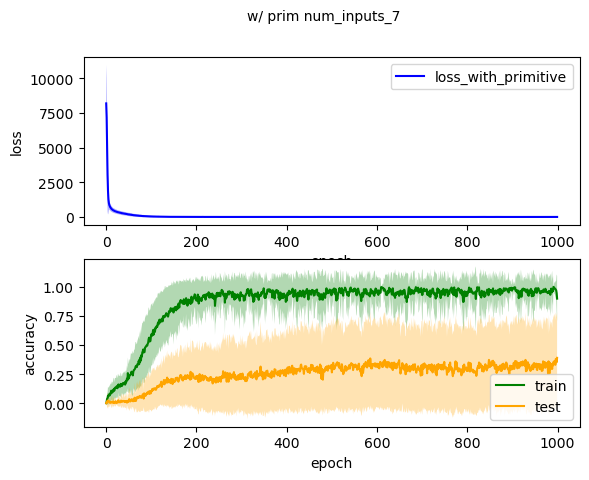

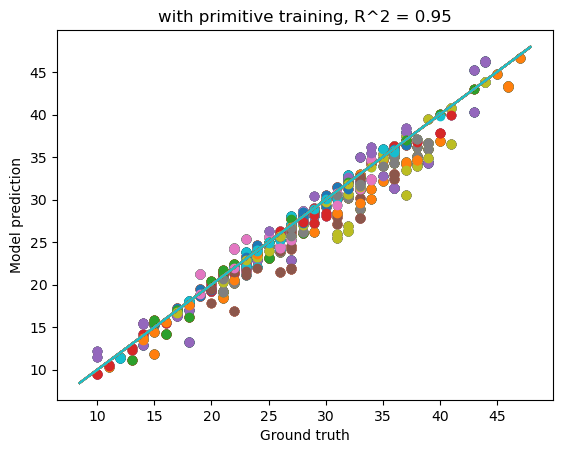

In [91]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [92]:
p_add = pad_seqs_1step(all_syms, cue_dict, padder = ('+', 'X'))
p_sub = pad_seqs_1step(all_syms, cue_dict, padder = ('-', 'X'))
train_add = pad_seqs_2step(generate_other_1step(['+'], all_syms[1:], all_syms[1:]), padder = ('+', 'X'))
train_sub = pad_seqs_2step(generate_other_1step(['-'], all_syms[1:], all_syms[1:]), padder = ('-', 'X'))
trainseqs = p_add + p_sub + train_add + train_sub
testseqs = test_other(['+', '-'], 'A', all_syms[1:], rep = 10)

time:  187.85723171631494
                           label       pred  acc
trial                                           
['B', '-', 'D', '+', 'A']    7.0  10.065482  0.0
['C', '+', 'A', '+', 'B']   34.0  27.477959  0.0
['C', '+', 'A', '-', 'F']   10.0  15.799572  0.0
['C', '+', 'D', '+', 'A']   41.0  32.199200  0.0
['C', '+', 'E', '+', 'A']   28.0  19.677658  0.0
['C', '-', 'A', '+', 'E']    0.0  18.419247  0.0
['C', '-', 'D', '-', 'A']  -19.0  -5.727864  0.0
['C', '-', 'F', '-', 'A']  -18.0  -9.271453  0.0
['D', '-', 'E', '-', 'A']   -1.0   0.607285  0.0
['E', '-', 'E', '-', 'A']  -14.0 -10.350455  0.0
                           label       pred  acc
trial                                           
['B', '-', 'D', '+', 'A']    9.5   7.839489  0.0
['C', '+', 'A', '+', 'B']   35.5  31.158106  0.0
['C', '+', 'A', '-', 'F']   14.0  17.685156  0.0
['C', '+', 'D', '+', 'A']   37.0  35.885618  0.0
['C', '+', 'E', '+', 'A']   33.5  34.401711  0.0
['C', '-', 'A', '+', 'E']   11.5  16.320044

                               label       pred       acc
trial                                                    
['C', '+', 'D', '+', 'A']  30.071429  27.019704  0.142857
['C', '+', 'A', '-', 'F']   9.000000  11.770776  0.071429
['C', '-', 'A', '+', 'E']   9.214286  11.663987  0.071429
['B', '-', 'D', '+', 'A']   7.857143   8.550763  0.000000
['C', '+', 'A', '+', 'B']  28.428571  25.808436  0.000000
['C', '+', 'E', '+', 'A']  28.214286  25.339885  0.000000
['C', '-', 'D', '-', 'A']  -9.785714  -6.017089  0.000000
['C', '-', 'F', '-', 'A'] -10.000000  -7.919540  0.000000
['D', '-', 'E', '-', 'A']  -7.642857  -6.749003  0.000000
['E', '-', 'E', '-', 'A']  -9.500000  -1.472643  0.000000
                               label       pred       acc
trial                                                    
['C', '+', 'D', '+', 'A']  29.933333  26.747685  0.133333
['C', '-', 'A', '+', 'E']   8.733333  11.031365  0.133333
['C', '+', 'A', '-', 'F']   8.600000  11.460346  0.066667
['B', '-', 'D'

                               label       pred       acc
trial                                                    
['C', '+', 'A', '+', 'B']  27.518519  25.835898  0.074074
['C', '+', 'A', '-', 'F']   8.259259  10.960018  0.074074
['C', '+', 'D', '+', 'A']  29.148148  26.751106  0.074074
['C', '-', 'A', '+', 'E']   8.851852  12.259926  0.074074
['B', '-', 'D', '+', 'A']   7.111111   8.729655  0.037037
['C', '+', 'E', '+', 'A']  26.333333  23.730662  0.037037
['C', '-', 'F', '-', 'A']  -9.222222  -6.927775  0.037037
['D', '-', 'E', '-', 'A']  -5.925926  -4.408339  0.037037
['C', '-', 'D', '-', 'A']  -9.962963  -5.709578  0.000000
['E', '-', 'E', '-', 'A']  -8.740741  -4.396148  0.000000
                               label       pred       acc
trial                                                    
['C', '+', 'A', '+', 'B']  27.392857  25.582570  0.071429
['C', '+', 'A', '-', 'F']   8.000000  11.323258  0.071429
['C', '+', 'D', '+', 'A']  28.857143  26.503154  0.071429
['C', '-', 'A'

                            label       pred    acc
trial                                              
['C', '+', 'A', '+', 'B']  26.900  24.822658  0.075
['C', '+', 'A', '-', 'F']   7.850  11.173520  0.075
['C', '+', 'D', '+', 'A']  29.475  27.095638  0.050
['C', '-', 'A', '+', 'E']   8.300  12.399936  0.050
['D', '-', 'E', '-', 'A']  -5.600  -3.506065  0.050
['E', '-', 'E', '-', 'A']  -8.925  -4.246098  0.050
['B', '-', 'D', '+', 'A']   6.350   7.765648  0.025
['C', '+', 'E', '+', 'A']  26.150  23.065342  0.025
['C', '-', 'D', '-', 'A'] -10.825  -4.816882  0.025
['C', '-', 'F', '-', 'A'] -10.000  -6.070252  0.025


label       pred    acc
trial                                              
['C', '+', 'A', '+', 'B']  26.900  24.822658  0.075
['C', '+', 'A', '-', 'F']   7.850  11.173520  0.075
['C', '+', 'D', '+', 'A']  29.475  27.095638  0.050
['C', '-', 'A', '+', 'E']   8.300  12.399936  0.050
['D', '-', 'E', '-', 'A']  -5.600  -3.506065  0.050
['E', '-', 'E', '-', 'A']  -8.925  -4.246098  0.050
['B', '-', 'D', '+', 'A']   6.350   7.765648  0.025
['C', '+', 'E', '+', 'A']  26.150  23.065342  0.025
['C', '-', 'D', '-', 'A'] -10.825  -4.816882  0.025
['C', '-', 'F', '-', 'A'] -10.000  -6.070252  0.025

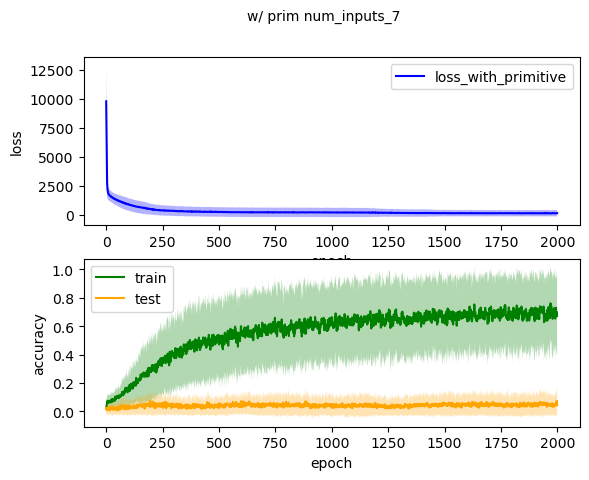

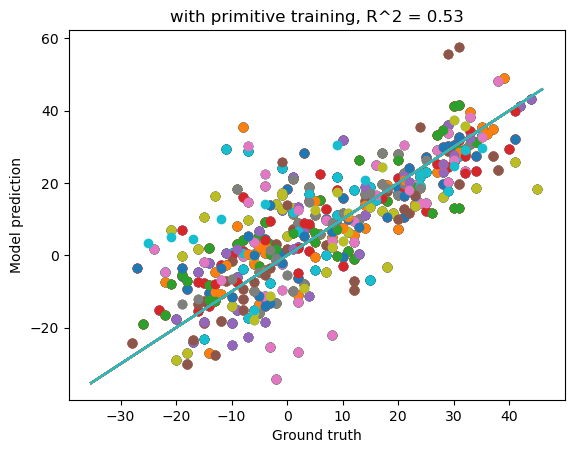

In [98]:
epochs = 2000

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [96]:
os.system("printf '\a'") # or '\7'



0

In [39]:
## 2

time:  9.113795236746471
                           label      pred  acc
trial                                          
['B', '-', 'I', '-', 'A']  -25.0 -9.702556  0.0
['D', '-', 'G', '-', 'A']  -20.0 -7.602247  0.0
['F', '-', 'F', '-', 'A']  -17.0 -5.511456  0.0
['F', '-', 'H', '-', 'A']   -5.0 -0.058209  0.0
['G', '-', 'A', '-', 'B']  -15.0 -5.671435  0.0
['G', '-', 'A', '-', 'E']  -18.0 -5.887239  0.0
['G', '-', 'D', '-', 'A']  -14.0 -6.493025  0.0
['J', '-', 'C', '-', 'A']  -18.0 -5.950260  0.0
['K', '-', 'H', '-', 'A']  -16.0 -9.093610  0.0
['K', '-', 'L', '-', 'A']  -25.0 -9.686610  0.0
                           label      pred  acc
trial                                          
['B', '-', 'I', '-', 'A']  -14.5 -4.092594  0.0
['D', '-', 'G', '-', 'A']  -14.0 -4.472284  0.0
['F', '-', 'F', '-', 'A']  -13.0 -5.026456  0.0
['F', '-', 'H', '-', 'A']  -13.0 -4.688300  0.0
['G', '-', 'A', '-', 'B']  -16.0 -3.913572  0.0
['G', '-', 'A', '-', 'E']  -13.0 -4.529387  0.0
['G', '-', 'D',

label      pred    acc
trial                                             
['G', '-', 'A', '-', 'B'] -10.375 -4.508906  0.125
['G', '-', 'A', '-', 'E'] -10.875 -4.359758  0.125
['K', '-', 'L', '-', 'A']  -7.500 -0.816801  0.125
['B', '-', 'I', '-', 'A'] -11.250 -3.156586  0.000
['D', '-', 'G', '-', 'A']  -7.375 -0.786510  0.000
['F', '-', 'F', '-', 'A']  -9.250 -2.143854  0.000
['F', '-', 'H', '-', 'A']  -9.625 -3.101143  0.000
['G', '-', 'D', '-', 'A'] -11.125 -3.965121  0.000
['J', '-', 'C', '-', 'A']  -9.875 -2.755772  0.000
['K', '-', 'H', '-', 'A']  -7.500 -1.239714  0.000

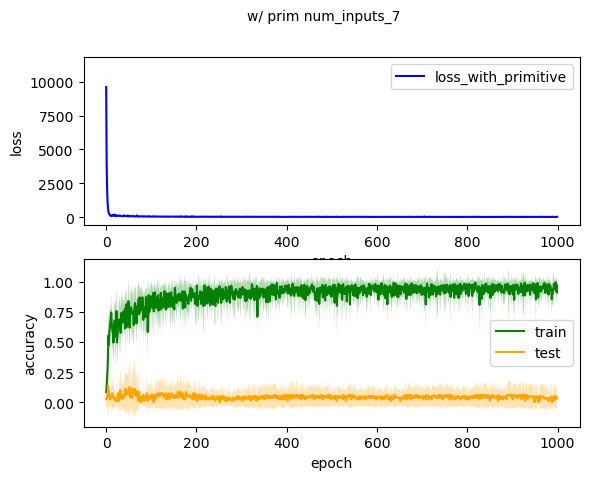

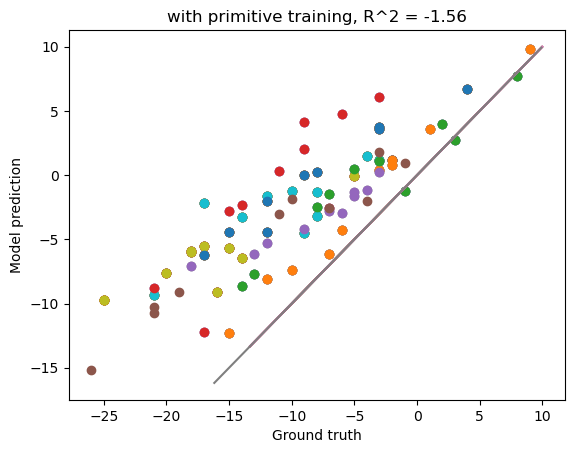

In [40]:
num_layers = 2
hidden_size = 20
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [41]:
## 3 

time:  7.939056428273519
                           label       pred  acc
trial                                           
['B', '-', 'I', '-', 'A']  -14.0  -7.224657  0.0
['D', '-', 'G', '-', 'A']  -17.0  -7.112225  0.0
['F', '-', 'F', '-', 'A']  -15.0  -6.481914  0.0
['F', '-', 'H', '-', 'A']  -10.0  -4.671728  0.0
['G', '-', 'A', '-', 'B']  -23.0 -16.109089  0.0
['G', '-', 'A', '-', 'E']  -26.0 -18.104023  0.0
['G', '-', 'D', '-', 'A']  -13.0  -4.786694  0.0
['J', '-', 'C', '-', 'A']  -21.0 -12.785499  0.0
['K', '-', 'H', '-', 'A']   -1.0   4.365789  0.0
['K', '-', 'L', '-', 'A']  -11.0  -4.595489  0.0
                           label       pred  acc
trial                                           
['B', '-', 'I', '-', 'A']  -15.0  -6.209113  0.0
['D', '-', 'G', '-', 'A']  -12.0  -4.814631  0.0
['F', '-', 'F', '-', 'A']  -14.0  -5.156123  0.0
['F', '-', 'H', '-', 'A']  -14.0  -5.345825  0.0
['G', '-', 'A', '-', 'B']  -18.5 -12.596107  0.0
['G', '-', 'A', '-', 'E']  -22.0 -14.270338 

label      pred    acc
trial                                             
['B', '-', 'I', '-', 'A'] -10.500 -5.504182  0.125
['D', '-', 'G', '-', 'A']  -8.250 -3.617180  0.125
['F', '-', 'H', '-', 'A']  -7.875 -3.252184  0.125
['G', '-', 'D', '-', 'A']  -6.250 -1.538872  0.125
['J', '-', 'C', '-', 'A']  -6.375 -2.307106  0.125
['K', '-', 'H', '-', 'A'] -10.500 -5.294434  0.125
['K', '-', 'L', '-', 'A'] -10.750 -5.858909  0.125
['F', '-', 'F', '-', 'A']  -7.250 -2.782734  0.000
['G', '-', 'A', '-', 'B']  -4.250 -1.001279  0.000
['G', '-', 'A', '-', 'E']  -7.000 -3.137045  0.000

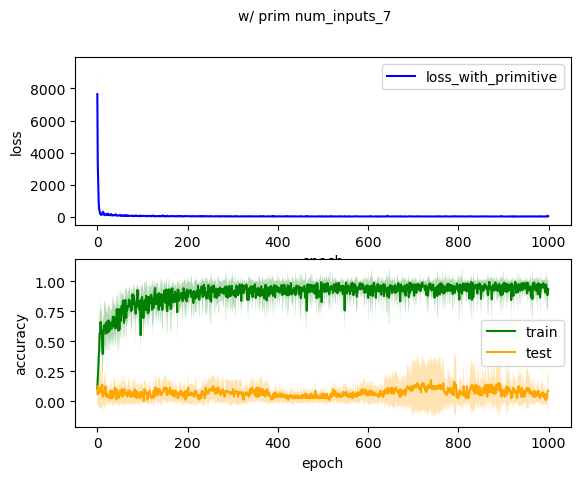

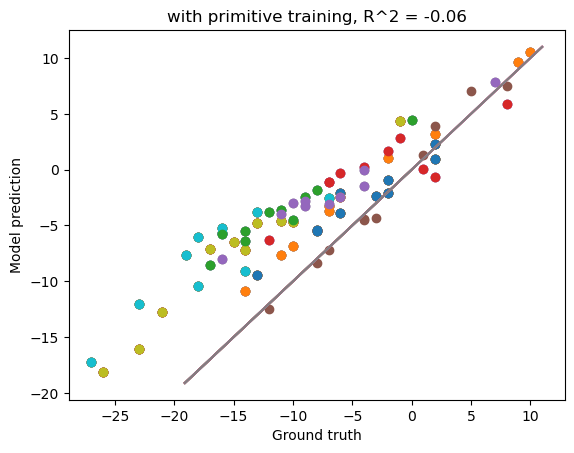

In [42]:
num_layers = 1
hidden_size = 40
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  8.01795015335083
                           label      pred  acc
trial                                          
['D', '-', 'G', '-', 'A']    1.0  1.408628  1.0
['B', '-', 'I', '-', 'A']   -9.0 -2.314125  0.0
['F', '-', 'F', '-', 'A']   -6.0  0.195970  0.0
['F', '-', 'H', '-', 'A']    0.0  2.310884  0.0
['G', '-', 'A', '-', 'B']   -9.0 -5.824925  0.0
['G', '-', 'A', '-', 'E']  -15.0 -7.172234  0.0
['G', '-', 'D', '-', 'A']  -13.0 -6.246599  0.0
['J', '-', 'C', '-', 'A']  -11.0 -4.287385  0.0
['K', '-', 'H', '-', 'A']    7.0  9.165018  0.0
['K', '-', 'L', '-', 'A']   -4.0  1.178035  0.0
                           label      pred  acc
trial                                          
['D', '-', 'G', '-', 'A']   -5.0 -1.708246  0.5
['B', '-', 'I', '-', 'A']   -9.5 -2.492447  0.0
['F', '-', 'F', '-', 'A']   -9.0 -3.598375  0.0
['F', '-', 'H', '-', 'A']   -6.5 -2.326274  0.0
['G', '-', 'A', '-', 'B']   -8.5 -4.005662  0.0
['G', '-', 'A', '-', 'E']   -8.5 -1.871222  0.0
['G', '-', 'D', 

label      pred   acc
trial                                            
['D', '-', 'G', '-', 'A']  -8.750 -4.053776  0.25
['B', '-', 'I', '-', 'A'] -12.875 -4.983347  0.00
['F', '-', 'F', '-', 'A'] -11.250 -5.494011  0.00
['F', '-', 'H', '-', 'A'] -11.375 -3.994585  0.00
['G', '-', 'A', '-', 'B'] -12.500 -6.172087  0.00
['G', '-', 'A', '-', 'E'] -14.000 -4.652131  0.00
['G', '-', 'D', '-', 'A'] -13.750 -5.606239  0.00
['J', '-', 'C', '-', 'A']  -9.750 -3.015549  0.00
['K', '-', 'H', '-', 'A']  -7.250 -0.798380  0.00
['K', '-', 'L', '-', 'A'] -11.125 -4.460928  0.00

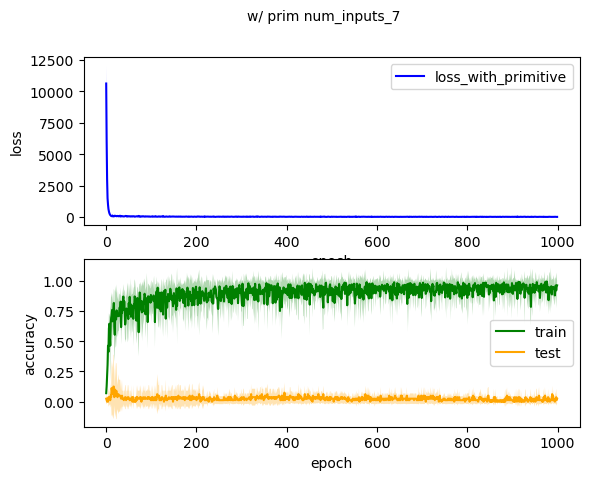

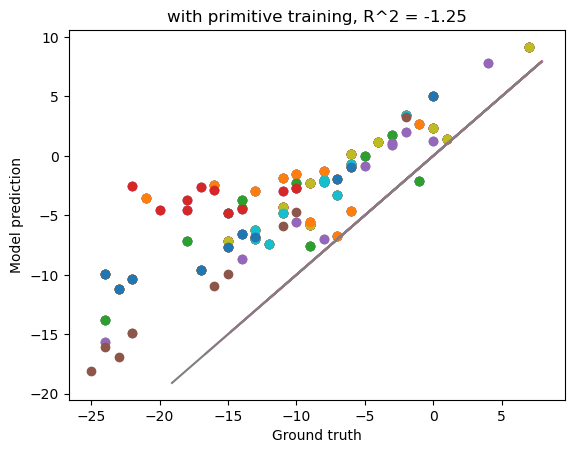

In [47]:
num_layers = 1
hidden_size = 10
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  13.10188470284144
                           label       pred  acc
trial                                           
['B', '-', 'I', '-', 'A']   -6.0  -2.053814  0.0
['D', '-', 'G', '-', 'A']  -19.0 -13.154769  0.0
['F', '-', 'F', '-', 'A']  -11.0  -1.330260  0.0
['F', '-', 'H', '-', 'A']  -13.0  -2.248519  0.0
['G', '-', 'A', '-', 'B']  -10.0  -1.836750  0.0
['G', '-', 'A', '-', 'E']  -17.0  -7.906763  0.0
['G', '-', 'D', '-', 'A']   -3.0  -0.510488  0.0
['J', '-', 'C', '-', 'A']  -18.0  -7.882710  0.0
['K', '-', 'H', '-', 'A']   -8.0   2.205647  0.0
['K', '-', 'L', '-', 'A']    0.0   5.397894  0.0
                           label       pred  acc
trial                                           
['G', '-', 'A', '-', 'B']   -6.5  -2.521779  0.5
['G', '-', 'D', '-', 'A']    0.5   1.763605  0.5
['B', '-', 'I', '-', 'A']   -4.0  -1.669648  0.0
['D', '-', 'G', '-', 'A']  -18.5 -12.580627  0.0
['F', '-', 'F', '-', 'A']   -9.0  -2.213300  0.0
['F', '-', 'H', '-', 'A']  -13.5  -5.250647 

label      pred    acc
trial                                             
['G', '-', 'D', '-', 'A']  -3.250 -0.343203  0.250
['K', '-', 'L', '-', 'A']  -7.000 -2.671289  0.250
['F', '-', 'H', '-', 'A']  -7.375 -3.016872  0.125
['G', '-', 'A', '-', 'B']  -6.625 -3.504048  0.125
['J', '-', 'C', '-', 'A']  -7.875 -4.101724  0.125
['K', '-', 'H', '-', 'A']  -8.750 -3.801576  0.125
['B', '-', 'I', '-', 'A']  -6.000 -3.223158  0.000
['D', '-', 'G', '-', 'A'] -11.250 -6.462818  0.000
['F', '-', 'F', '-', 'A']  -7.250 -3.181100  0.000
['G', '-', 'A', '-', 'E']  -6.250 -3.148107  0.000

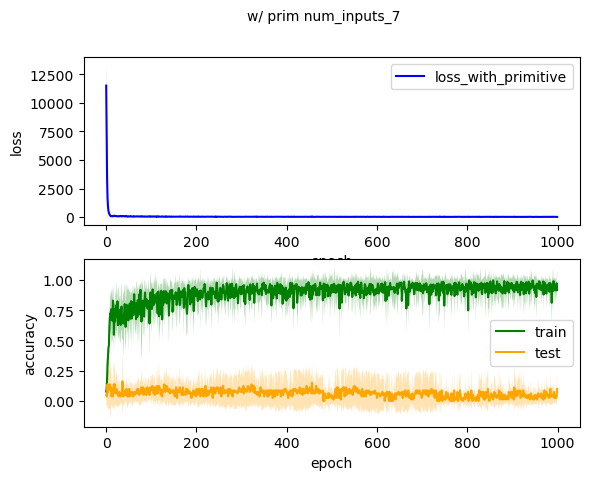

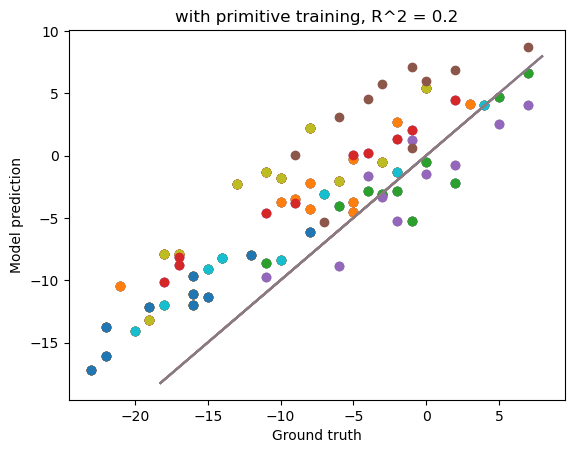

In [49]:
num_layers = 2
hidden_size = 10
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  7.933715665340424
                           label      pred  acc
trial                                          
['B', '-', 'I', '-', 'A']  -16.0 -1.714730  0.0
['D', '-', 'G', '-', 'A']  -15.0 -0.844044  0.0
['F', '-', 'F', '-', 'A']  -11.0  0.253094  0.0
['F', '-', 'H', '-', 'A']  -10.0  0.263884  0.0
['G', '-', 'A', '-', 'B']   -8.0  0.157087  0.0
['G', '-', 'A', '-', 'E']   -5.0 -0.726906  0.0
['G', '-', 'D', '-', 'A']   -7.0 -0.464689  0.0
['J', '-', 'C', '-', 'A']   -7.0  0.542763  0.0
['K', '-', 'H', '-', 'A']  -23.0 -8.739271  0.0
['K', '-', 'L', '-', 'A']  -14.0 -0.331589  0.0
                           label       pred  acc
trial                                           
['G', '-', 'A', '-', 'E']   -3.0  -1.001308  0.5
['B', '-', 'I', '-', 'A']  -10.5  -1.878346  0.0
['D', '-', 'G', '-', 'A']  -12.5  -3.737404  0.0
['F', '-', 'F', '-', 'A']  -11.0  -3.744517  0.0
['F', '-', 'H', '-', 'A']   -9.0  -2.378518  0.0
['G', '-', 'A', '-', 'B']  -11.5  -5.046386  0.0
['G', '

label      pred    acc
trial                                             
['B', '-', 'I', '-', 'A']  -6.500 -1.431711  0.125
['F', '-', 'F', '-', 'A']  -7.500 -2.766660  0.125
['F', '-', 'H', '-', 'A']  -6.875 -2.439407  0.125
['G', '-', 'A', '-', 'E']  -3.750 -0.830764  0.125
['G', '-', 'D', '-', 'A']  -3.125 -0.266964  0.125
['J', '-', 'C', '-', 'A']  -4.875 -1.703641  0.125
['K', '-', 'H', '-', 'A']  -9.625 -4.425374  0.125
['D', '-', 'G', '-', 'A'] -11.875 -5.542052  0.000
['G', '-', 'A', '-', 'B']  -7.250 -3.590020  0.000
['K', '-', 'L', '-', 'A']  -7.875 -3.198554  0.000

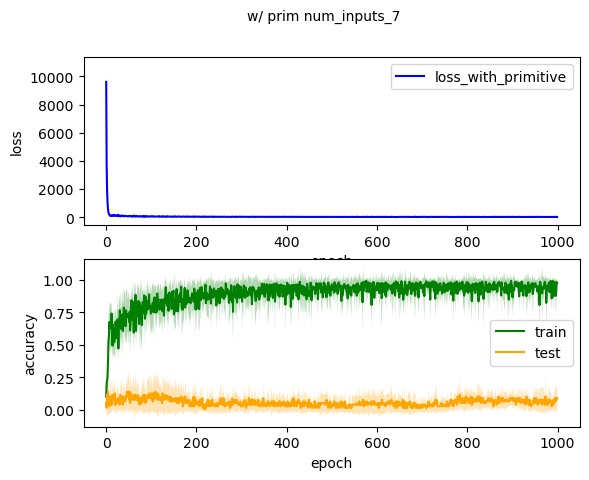

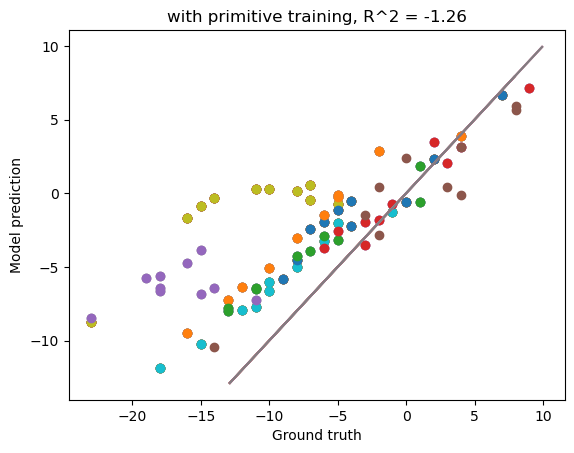

In [50]:
num_layers = 2
hidden_size = 20
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  12.477030634880066
                           label      pred  acc
trial                                          
['B', '-', 'I', '-', 'A']    2.0  2.822879  0.0
['D', '-', 'G', '-', 'A']   -9.0 -6.172244  0.0
['F', '-', 'F', '-', 'A']   -4.0 -1.649458  0.0
['F', '-', 'H', '-', 'A']  -12.0 -8.744441  0.0
['G', '-', 'A', '-', 'B']   -9.0 -6.472413  0.0
['G', '-', 'A', '-', 'E']  -11.0 -8.147532  0.0
['G', '-', 'D', '-', 'A']    1.0 -1.855662  0.0
['J', '-', 'C', '-', 'A']  -13.0 -9.733477  0.0
['K', '-', 'H', '-', 'A']   -8.0 -6.981989  0.0
['K', '-', 'L', '-', 'A']   -6.0 -5.055349  0.0
                           label      pred  acc
trial                                          
['B', '-', 'I', '-', 'A']   -2.5  0.071301  0.0
['D', '-', 'G', '-', 'A']  -15.0 -8.104238  0.0
['F', '-', 'F', '-', 'A']   -9.5 -4.895427  0.0
['F', '-', 'H', '-', 'A']  -12.0 -7.888062  0.0
['G', '-', 'A', '-', 'B']  -10.5 -7.900486  0.0
['G', '-', 'A', '-', 'E']   -8.0 -5.861234  0.0
['G', '-', 'D'

label      pred    acc
trial                                             
['B', '-', 'I', '-', 'A']  -4.625 -1.063553  0.125
['J', '-', 'C', '-', 'A'] -13.625 -7.252597  0.125
['D', '-', 'G', '-', 'A']  -8.750 -3.665923  0.000
['F', '-', 'F', '-', 'A']  -8.625 -5.569980  0.000
['F', '-', 'H', '-', 'A'] -11.000 -6.565342  0.000
['G', '-', 'A', '-', 'B']  -9.375 -6.492253  0.000
['G', '-', 'A', '-', 'E']  -9.375 -6.186252  0.000
['G', '-', 'D', '-', 'A']  -8.500 -3.465933  0.000
['K', '-', 'H', '-', 'A'] -11.250 -6.148276  0.000
['K', '-', 'L', '-', 'A'] -11.500 -6.148007  0.000

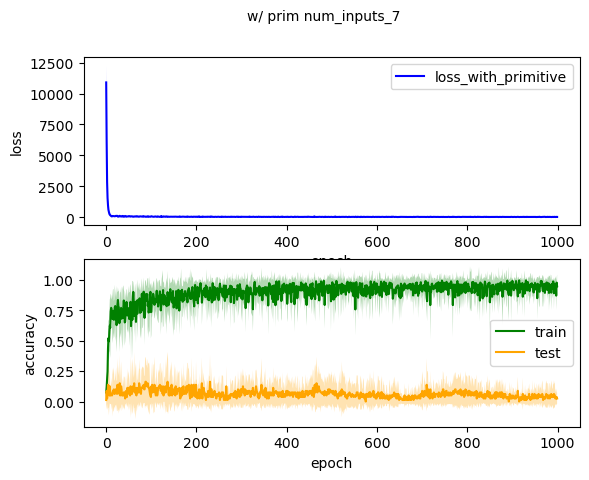

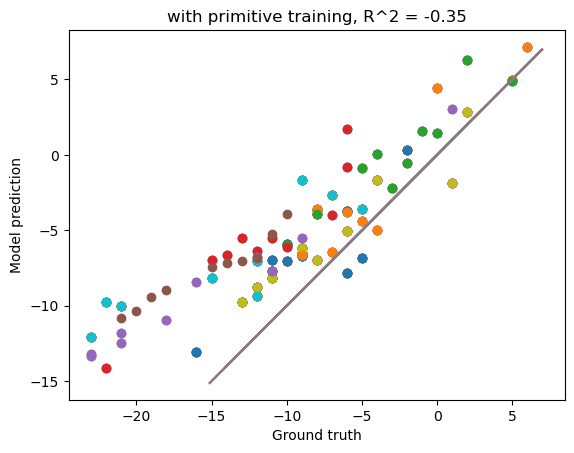

In [51]:
num_layers = 1
hidden_size = 10
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  38.9906467517217
                           label      pred  acc
trial                                          
['B', '-', 'I', '-', 'A']   -5.0 -0.644579  0.0
['D', '-', 'G', '-', 'A']  -12.0 -5.002043  0.0
['F', '-', 'F', '-', 'A']   -6.0 -3.020787  0.0
['F', '-', 'H', '-', 'A']   -3.0  0.030568  0.0
['G', '-', 'A', '-', 'B']   -5.0 -2.691944  0.0
['G', '-', 'A', '-', 'E']   -3.0 -0.674384  0.0
['G', '-', 'D', '-', 'A']    0.0  3.115228  0.0
['J', '-', 'C', '-', 'A']   -2.0  0.196646  0.0
['K', '-', 'H', '-', 'A']  -11.0 -4.683428  0.0
['K', '-', 'L', '-', 'A']    1.0  2.031941  0.0
                           label      pred  acc
trial                                          
['B', '-', 'I', '-', 'A']   -5.0  0.046523  0.0
['D', '-', 'G', '-', 'A']   -6.0  0.169218  0.0
['F', '-', 'F', '-', 'A']   -7.0 -0.066409  0.0
['F', '-', 'H', '-', 'A']  -10.5 -3.455292  0.0
['G', '-', 'A', '-', 'B']   -7.0 -2.621194  0.0
['G', '-', 'A', '-', 'E']   -9.0 -3.770635  0.0
['G', '-', 'D', 

label      pred    acc
trial                                             
['D', '-', 'G', '-', 'A']  -6.875 -1.623249  0.125
['G', '-', 'A', '-', 'E']  -6.625 -3.501440  0.125
['J', '-', 'C', '-', 'A']  -9.875 -3.829222  0.125
['K', '-', 'L', '-', 'A']  -2.750  1.582575  0.125
['B', '-', 'I', '-', 'A']  -3.250  0.678357  0.000
['F', '-', 'F', '-', 'A']  -7.625 -2.509684  0.000
['F', '-', 'H', '-', 'A'] -11.000 -4.560284  0.000
['G', '-', 'A', '-', 'B']  -7.375 -4.261701  0.000
['G', '-', 'D', '-', 'A']  -8.375 -2.773514  0.000
['K', '-', 'H', '-', 'A']  -6.625 -0.915537  0.000

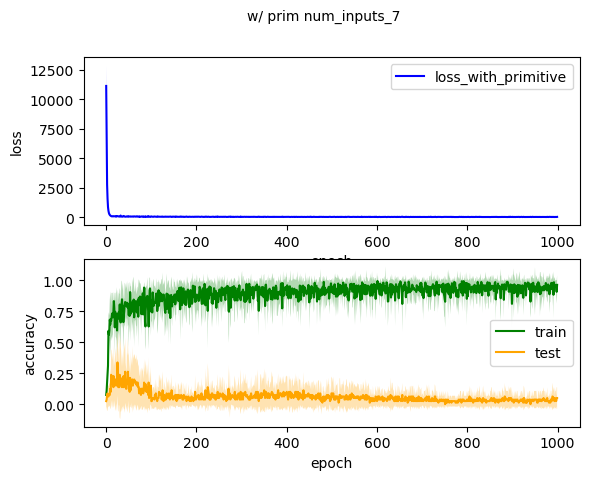

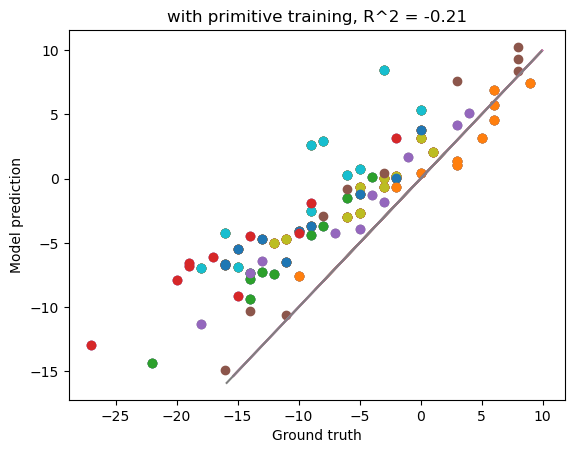

In [52]:
num_layers = 2
hidden_size = 8
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  19.04920645157496
                           label       pred  acc
trial                                           
['B', '-', 'I', '-', 'A']  -15.0 -15.030929  1.0
['D', '-', 'G', '-', 'A']  -19.0 -18.974697  1.0
['F', '-', 'F', '-', 'A']  -11.0 -11.018552  1.0
['F', '-', 'H', '-', 'A']  -13.0 -12.985919  1.0
['G', '-', 'A', '-', 'B']   -4.0  -4.473899  1.0
['G', '-', 'A', '-', 'E']  -10.0 -10.467196  1.0
['G', '-', 'D', '-', 'A']   -3.0  -3.022891  1.0
['J', '-', 'C', '-', 'A']  -18.0 -17.956779  1.0
['K', '-', 'H', '-', 'A']  -22.0 -21.795446  1.0
['K', '-', 'L', '-', 'A']  -10.0  -9.979134  1.0
                           label       pred  acc
trial                                           
['B', '-', 'I', '-', 'A']  -10.0  -6.180258  0.5
['D', '-', 'G', '-', 'A']  -17.0 -14.081753  0.5
['F', '-', 'F', '-', 'A']  -11.5  -9.258751  0.5
['F', '-', 'H', '-', 'A']  -11.0  -9.132106  0.5
['G', '-', 'A', '-', 'B']  -12.5 -10.550098  0.5
['G', '-', 'A', '-', 'E']  -14.5 -12.737222 

label       pred    acc
trial                                              
['D', '-', 'G', '-', 'A'] -11.125  -8.554832  0.500
['F', '-', 'H', '-', 'A']  -8.875  -6.559393  0.375
['J', '-', 'C', '-', 'A']  -7.625  -4.600051  0.375
['B', '-', 'I', '-', 'A'] -10.000  -7.329976  0.250
['F', '-', 'F', '-', 'A'] -10.500  -7.603352  0.250
['G', '-', 'D', '-', 'A']  -9.875  -6.781929  0.250
['K', '-', 'H', '-', 'A'] -11.625  -9.498972  0.250
['K', '-', 'L', '-', 'A'] -10.125  -8.221253  0.250
['G', '-', 'A', '-', 'B'] -11.000  -7.498836  0.125
['G', '-', 'A', '-', 'E'] -14.000 -10.565929  0.125

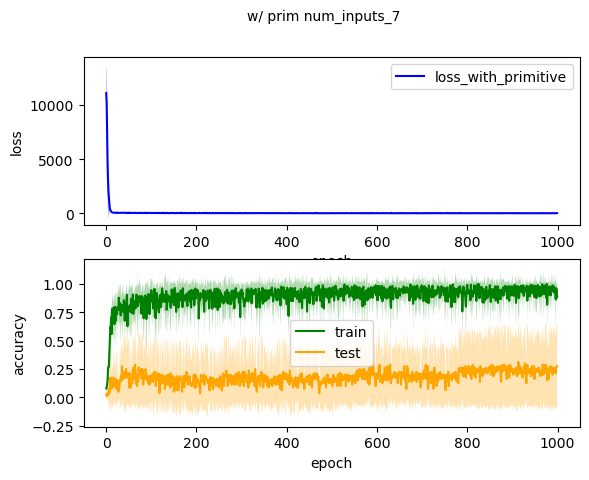

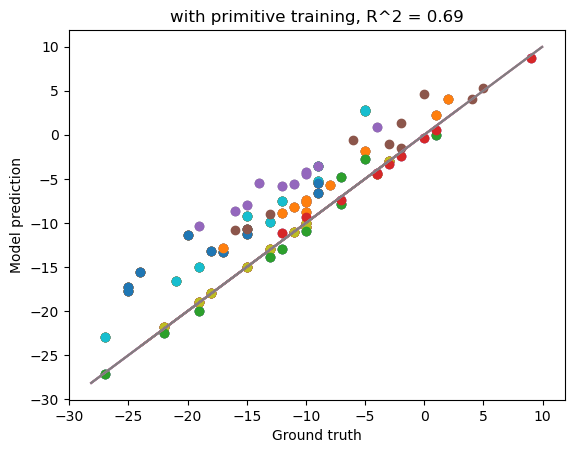

In [53]:
num_layers = 2
hidden_size = 5
learningRate = 0.005

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# Experiments

With P
1. All permutations of 2 step + p
2. All permutations of 1 step + p
3. Only "Other" permutations of 1 step (B+C),(C+D) ... + p
4. Only "Self" permutations of 1 step (B+B),(D+D) ... + p
5. Min set of Xother (X+C),(X+B) .. + p

Without P


In [26]:
# params

# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.001

## running params
epochs = 1000
num_sims = 80
num_inputs = 5

In [33]:
epochs = 1000
num_sims = 8
num_inputs = 12

In [34]:
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {'X':0}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)

{'X': 0, 'A': 11, 'B': 2, 'C': 13, 'D': 7, 'E': 6, 'F': 8, 'G': 16, 'H': 17, 'I': 4, 'J': 3, 'K': 9, 'L': 5}


# 1. All permuatations of 2 step

In [8]:
## running params
epochs = 1000
num_sims = 16

time:  9.078370535373688


label      pred     acc
trial                                               
['B', '-', 'C', '-', 'A'] -10.2500 -8.881843  0.0625
['D', '-', 'C', '-', 'A']  -8.3125 -6.941775  0.0625
['D', '-', 'D', '-', 'A']  -9.6250 -8.308769  0.0625
['B', '-', 'A', '-', 'D'] -11.5625 -8.253638  0.0000
['C', '-', 'A', '-', 'E']  -9.8750 -6.941706  0.0000
['E', '-', 'A', '-', 'D'] -10.6875 -7.641168  0.0000
['E', '-', 'A', '-', 'E']  -9.6250 -6.577826  0.0000

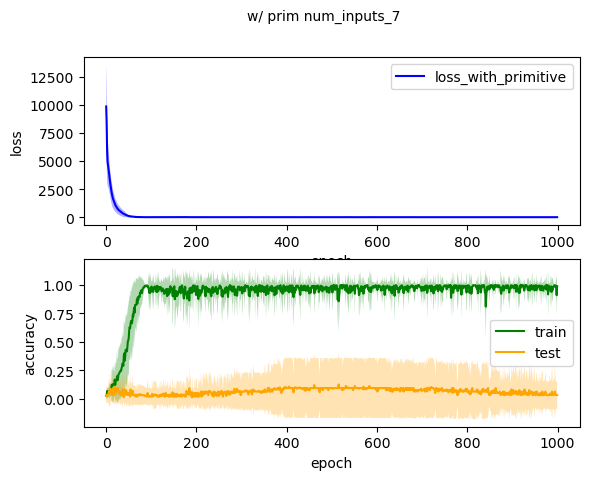

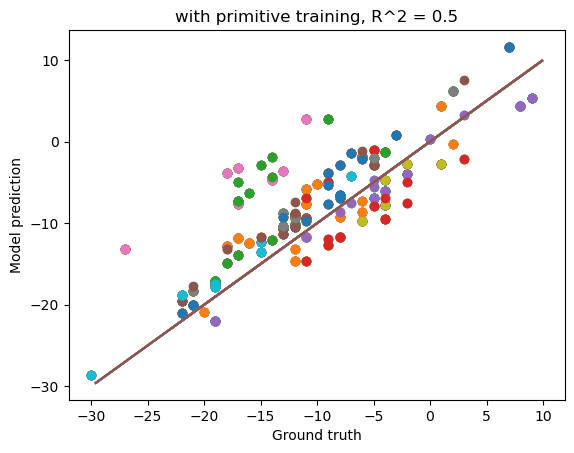

In [14]:
## std = 1
ops = ['-']
p = pad_seqs_1step(all_syms, cue_dict, padder = ('-','X'))
trainseqs = p + generate_sequences(ops, all_syms[1:], len_seq = 2, cue_dict = cue_dict, init_values = all_syms[1:])
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)
testseqs = [val for val in testseqs if val not in trainseqs]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  9.489529164632161


label       pred     acc
trial                                                
['B', '-', 'A', '-', 'C'] -10.2500  -9.433467  0.1250
['C', '-', 'A', '-', 'D']  -7.9375  -9.281631  0.1250
['B', '-', 'A', '-', 'B']  -9.1250  -8.987063  0.0625
['B', '-', 'A', '-', 'E']  -9.6250  -9.212526  0.0625
['B', '-', 'D', '-', 'A']  -9.0625 -10.354015  0.0625
['C', '-', 'A', '-', 'B']  -8.0000  -8.007261  0.0625
['E', '-', 'C', '-', 'A']  -9.7500  -9.208483  0.0625
['B', '-', 'C', '-', 'A'] -10.2500  -9.711454  0.0000
['C', '-', 'D', '-', 'A']  -7.9375  -9.601525  0.0000
['E', '-', 'A', '-', 'D']  -8.5625  -9.812986  0.0000

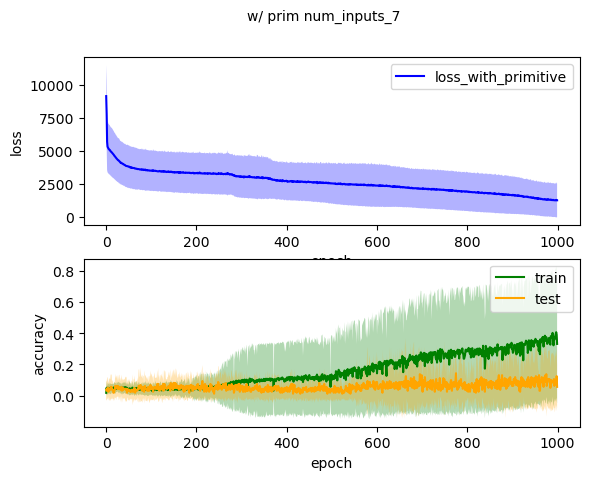

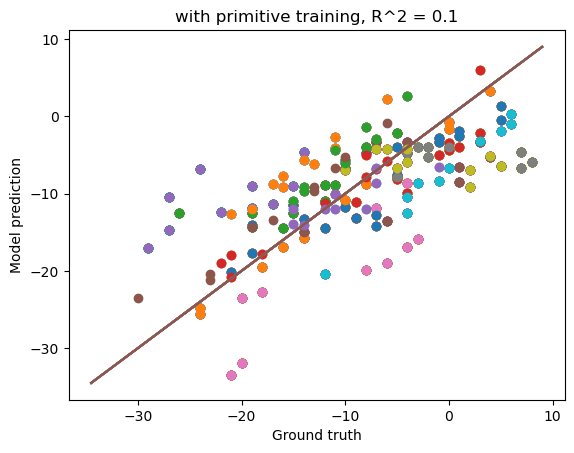

In [16]:
## std = 0.01
ops = ['-']
p = pad_seqs_1step(all_syms, cue_dict, padder = ('-','X'))
trainseqs = p + generate_sequences(ops, all_syms[1:], len_seq = 2, cue_dict = cue_dict, init_values = all_syms[1:])
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)
testseqs = [val for val in testseqs if val not in trainseqs]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  4.465961702664694


label       pred     acc
trial                                                
['D', '-', 'C', '-', 'A']  -7.1250  -8.501968  0.0625
['B', '-', 'A', '-', 'E'] -10.0625  97.994042  0.0000
['B', '-', 'B', '-', 'A'] -10.0000  -7.490292  0.0000
['B', '-', 'C', '-', 'A']  -9.5625  -9.707732  0.0000
['C', '-', 'C', '-', 'A'] -10.0000  -4.828407  0.0000
['C', '-', 'E', '-', 'A'] -10.5000 -15.865898  0.0000
['D', '-', 'B', '-', 'A']  -7.5625  -9.536115  0.0000

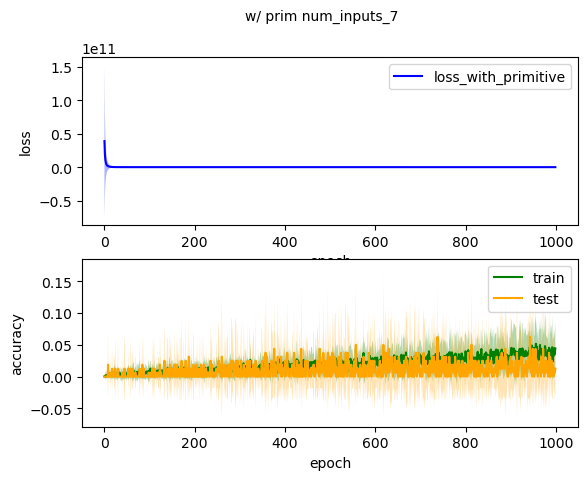

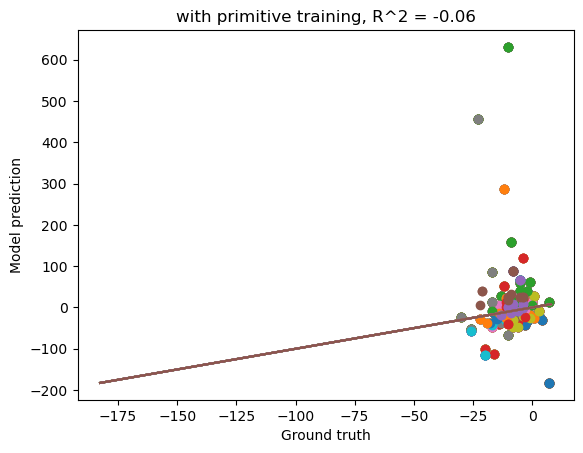

In [10]:
## std = 10
ops = ['-']
p = pad_seqs_1step(all_syms, cue_dict, padder = ('-','X'))
trainseqs = p + generate_sequences(ops, all_syms[1:], len_seq = 2, cue_dict = cue_dict, init_values = all_syms[1:])
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)
testseqs = [val for val in testseqs if val not in trainseqs]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [13]:
ops = ['-']
p = pad_seqs_1step(all_syms, cue_dict, padder = ('-','X'))
trainseqs = p + pad_seqs_2step(generate_other_1step(ops, all_syms[1:], all_syms[1:]), padder = ('-','X'))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)


time:  7.551221382617951


0

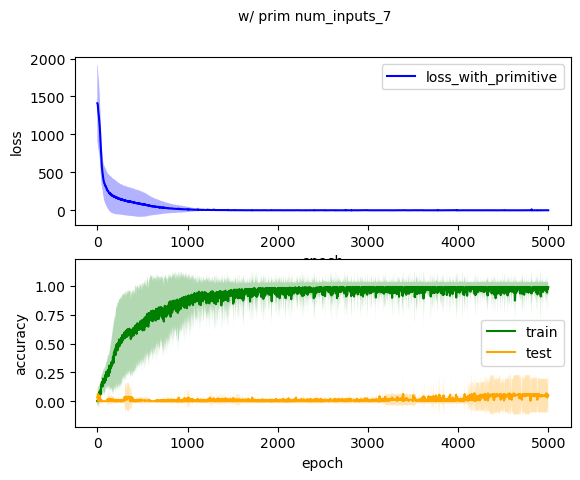

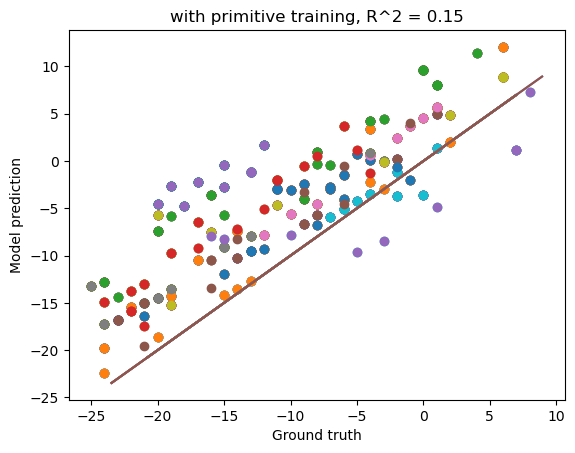

In [16]:
# std = 0.1
ops = ['-']
p = pad_seqs_1step(all_syms, cue_dict, padder = ('-','X'))
trainseqs = p + pad_seqs_2step(generate_other_1step(ops, all_syms[1:], all_syms[1:]), padder = ('-','X'))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res4  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res4])
acc_train = np.array([r['acc'][:,0] for r in res4]).T
acc_test = np.array([r['acc'][:,1] for r in res4]).T
mods = [r['mod'] for r in res4]
tests = [r['test'] for r in res4]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)
os.system("printf '\a'") # or '\7'


time:  10.749459985891978
                           label      pred  acc
trial                                          
['C', '-', 'A', '-', 'C']   -4.0 -7.346585  0.0
['C', '-', 'C', '-', 'A']   -4.0 -0.965426  0.0
['D', '-', 'C', '-', 'A']  -12.0 -6.179357  0.0
['E', '-', 'A', '-', 'C']   -6.0 -9.312678  0.0
['E', '-', 'A', '-', 'E']   -4.0 -6.519243  0.0
['E', '-', 'B', '-', 'A']   -5.0 -7.712083  0.0
['E', '-', 'E', '-', 'A']   -4.0 -0.617348  0.0
                           label       pred  acc
trial                                           
['C', '-', 'A', '-', 'C']   -9.0 -10.019317  0.0
['C', '-', 'C', '-', 'A']   -9.0  -6.693793  0.0
['D', '-', 'C', '-', 'A']  -16.0  -6.478332  0.0
['E', '-', 'A', '-', 'C']   -9.5 -10.554572  0.0
['E', '-', 'A', '-', 'E']   -9.0  -9.673774  0.0
['E', '-', 'B', '-', 'A']  -10.0 -10.208572  0.0
['E', '-', 'E', '-', 'A']   -9.0  -6.595134  0.0
                               label      pred  acc
trial                                            

0

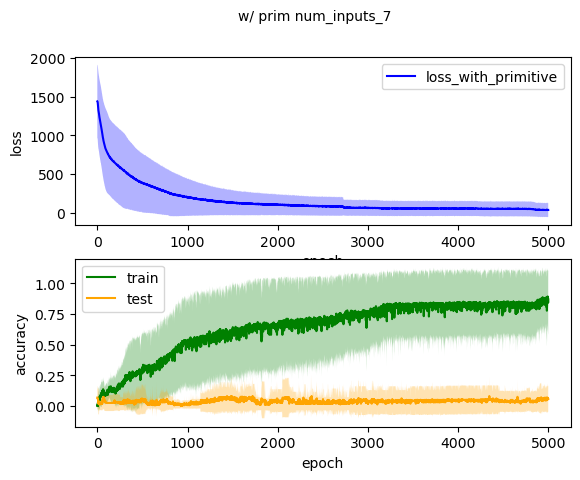

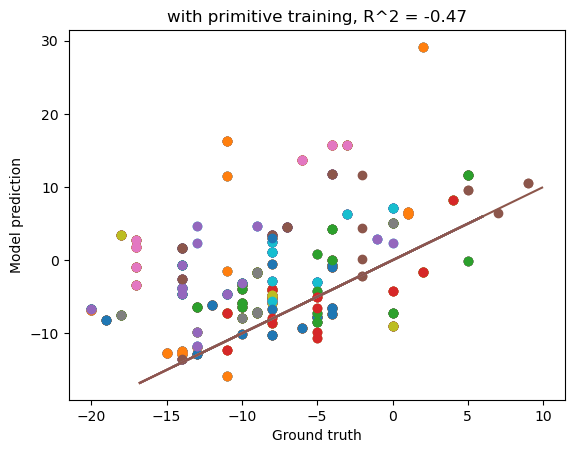

In [21]:
# std = 0.01
ops = ['-']
p = pad_seqs_1step(all_syms, cue_dict, padder = ('-','X'))
trainseqs = p + pad_seqs_2step(generate_other_1step(ops, all_syms[1:], all_syms[1:]), padder = ('-','X'))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res4  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res4])
acc_train = np.array([r['acc'][:,0] for r in res4]).T
acc_test = np.array([r['acc'][:,1] for r in res4]).T
mods = [r['mod'] for r in res4]
tests = [r['test'] for r in res4]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)
os.system("printf '\a'") # or '\7'


# exp 2 - all permutations of 1 step

time:  49.02145229578018


label       pred     acc
trial                                                
['B', '+', 'A', '+', 'B']  26.1875  26.199919  0.9375
['B', '+', 'A', '+', 'C']  27.1375  27.146325  0.9375
['C', '+', 'A', '+', 'C']  28.0875  28.099139  0.9375
['D', '+', 'A', '+', 'B']  27.0250  27.044635  0.9375
['E', '+', 'A', '+', 'C']  28.3125  28.321686  0.9375
['B', '+', 'A', '+', 'D']  27.0250  27.037485  0.9250
['B', '+', 'B', '+', 'A']  26.1875  26.212494  0.9250
['D', '+', 'B', '+', 'A']  27.0250  27.056552  0.9250
['C', '+', 'C', '+', 'A']  28.0875  28.110415  0.9000

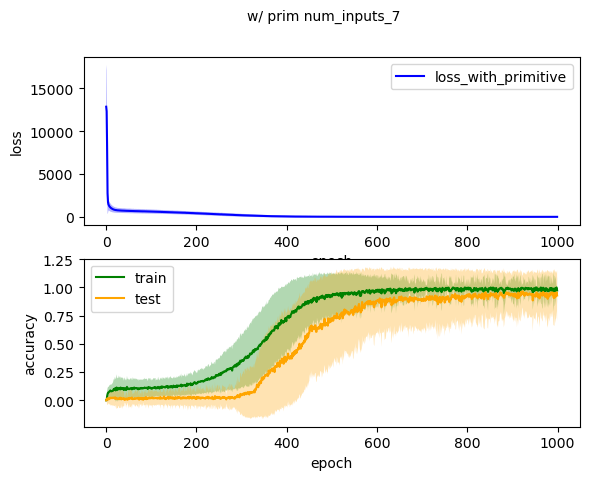

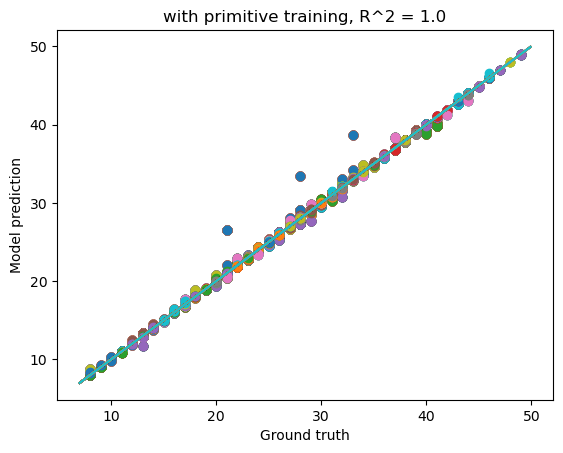

In [8]:
ops = ['+']
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_sequences(['+'], all_syms[1:], len_seq = 1, cue_dict = cue_dict, init_values = all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res2  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res2])
acc_train = np.array([r['acc'][:,0] for r in res2]).T
acc_test = np.array([r['acc'][:,1] for r in res2]).T
mods = [r['mod'] for r in res2]
tests = [r['test'] for r in res2]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# exp 3 - Min set of self

time:  5.225731619199117


label       pred     acc
trial                                                
['D', '+', 'A', '+', 'C']  27.7250  23.976550  0.1500
['B', '+', 'B', '+', 'A']  29.4625  25.854227  0.1125
['C', '+', 'A', '+', 'B']  28.4125  24.272765  0.0625
['E', '+', 'A', '+', 'C']  27.5000  23.788360  0.0625
['B', '+', 'D', '+', 'A']  28.7750  25.490155  0.0500
['C', '+', 'A', '+', 'D']  27.7250  24.099637  0.0500

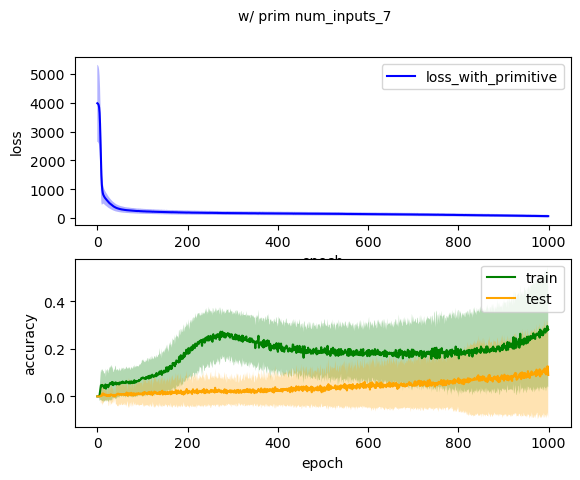

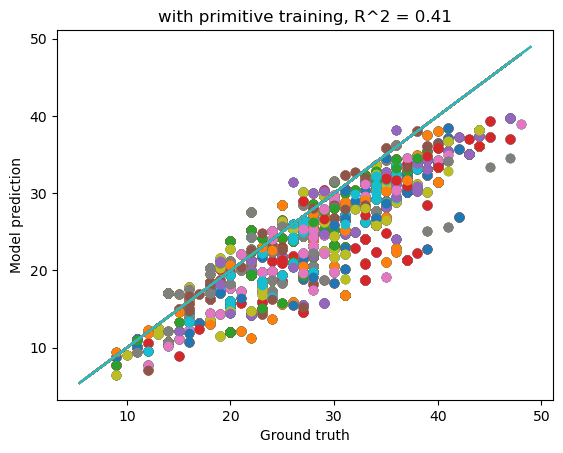

In [13]:
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_self_1step(ops, all_syms[1:], all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res3  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res3])
acc_train = np.array([r['acc'][:,0] for r in res3]).T
acc_test = np.array([r['acc'][:,1] for r in res3]).T
mods = [r['mod'] for r in res3]
tests = [r['test'] for r in res3]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# exp 4 -  Double set of other

time:  8.95976812839508


label       pred     acc
trial                                                
['C', '+', 'A', '+', 'D']  30.0125  30.096527  0.9000
['B', '+', 'A', '+', 'D']  28.4625  28.556562  0.8875
['D', '+', 'A', '+', 'C']  30.0125  30.105587  0.8875
['C', '+', 'A', '+', 'E']  28.9625  29.036657  0.8750
['D', '+', 'B', '+', 'A']  28.4625  28.470538  0.8750
['B', '+', 'A', '+', 'C']  28.7750  28.875479  0.8625
['D', '+', 'A', '+', 'E']  28.6500  28.726789  0.8625
['E', '+', 'D', '+', 'A']  28.6500  28.680490  0.8625
['B', '+', 'E', '+', 'A']  27.4125  27.441873  0.8250

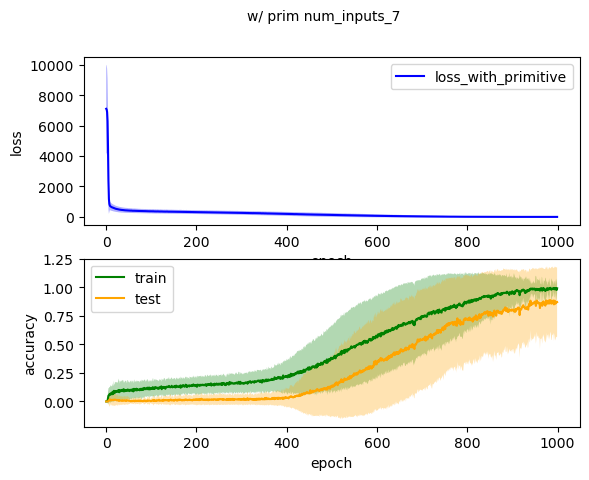

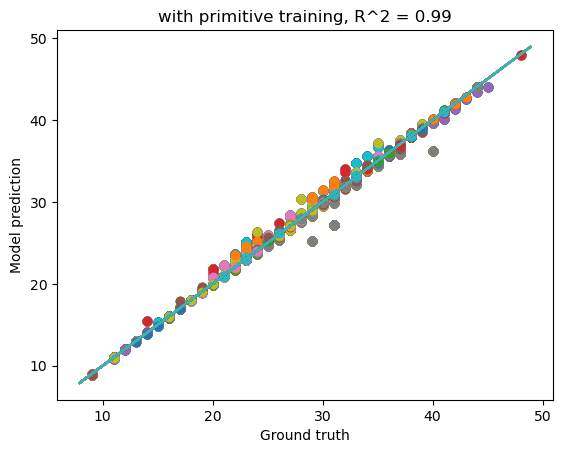

In [29]:
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_other_1step(ops, all_syms[1:], all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res4  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res4])
acc_train = np.array([r['acc'][:,0] for r in res4]).T
acc_test = np.array([r['acc'][:,1] for r in res4]).T
mods = [r['mod'] for r in res4]
tests = [r['test'] for r in res4]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# exp 5 -  Min set of other

time:  40.40326324701309


label       pred     acc
trial                                                
['B', '+', 'A', '+', 'C']  27.4750  26.709736  0.5125
['D', '+', 'B', '+', 'A']  28.4875  28.053862  0.3625
['E', '+', 'A', '+', 'C']  27.3250  26.688375  0.3625
['B', '+', 'A', '+', 'E']  28.0125  26.928712  0.3375
['C', '+', 'A', '+', 'E']  27.3250  26.226229  0.3375
['D', '+', 'D', '+', 'A']  28.8125  28.223227  0.3250
['D', '+', 'A', '+', 'D']  28.8125  27.859863  0.3125
['E', '+', 'A', '+', 'E']  27.8625  26.907350  0.2875
['C', '+', 'C', '+', 'A']  26.7875  26.163739  0.2750

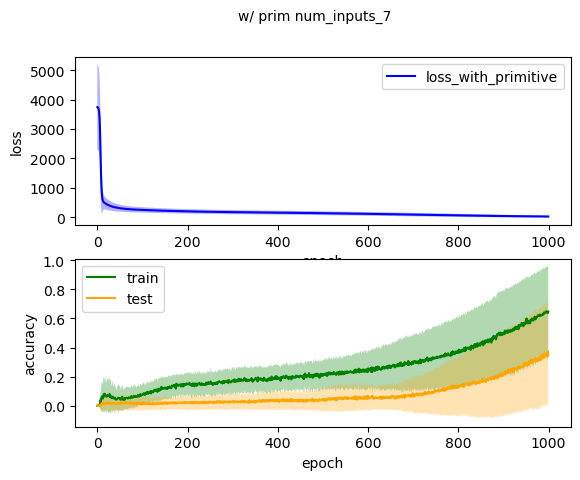

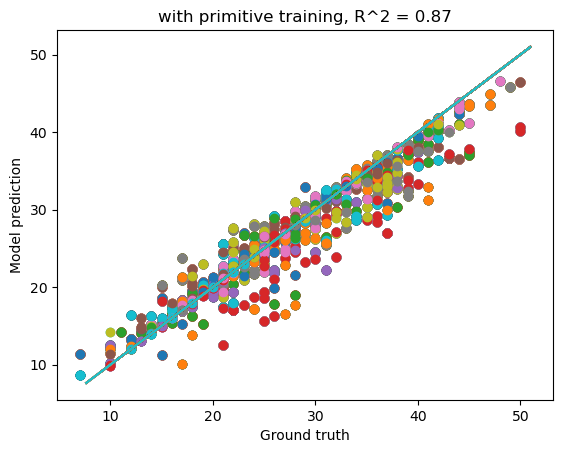

In [30]:
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_min_other(ops, all_syms[1:], all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res5  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res5])
acc_train = np.array([r['acc'][:,0] for r in res5]).T
acc_test = np.array([r['acc'][:,1] for r in res5]).T
mods = [r['mod'] for r in res5]
tests = [r['test'] for r in res5]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [32]:
epochs = 4000

time:  36.586433068911234


label       pred     acc
trial                                                
['B', '+', 'A', '+', 'D']  28.1500  28.168747  0.9500
['E', '+', 'A', '+', 'B']  28.1750  28.192387  0.9500
['D', '+', 'A', '+', 'C']  28.9375  28.951779  0.9375
['B', '+', 'B', '+', 'A']  27.8000  27.733167  0.9125
['C', '+', 'B', '+', 'A']  28.5875  28.518476  0.9000
['D', '+', 'D', '+', 'A']  28.5000  28.419517  0.9000
['E', '+', 'D', '+', 'A']  28.5250  28.446773  0.9000
['C', '+', 'D', '+', 'A']  28.9375  28.861718  0.8875
['E', '+', 'E', '+', 'A']  28.5500  28.458879  0.8750

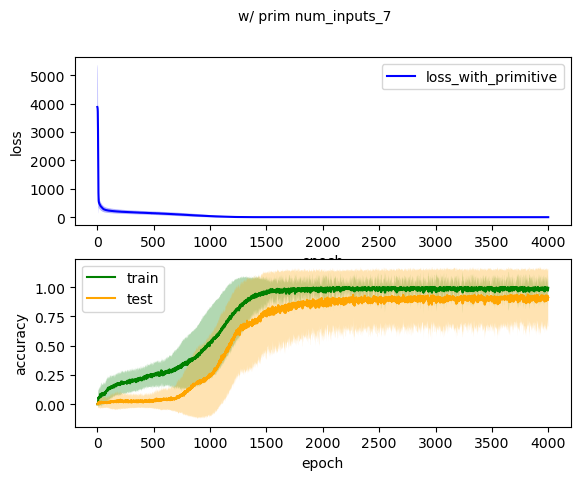

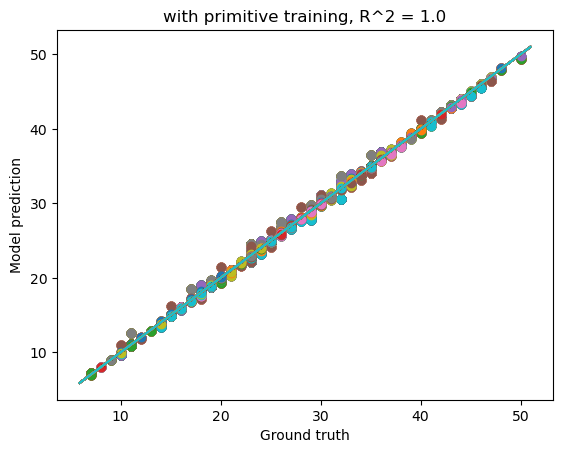

In [42]:
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_min_other(ops, all_syms[1:], all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res5  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res5])
acc_train = np.array([r['acc'][:,0] for r in res5]).T
acc_test = np.array([r['acc'][:,1] for r in res5]).T
mods = [r['mod'] for r in res5]
tests = [r['test'] for r in res5]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  36.089110998312634


label       pred     acc
trial                                                
['D', '+', 'A', '+', 'B']  27.3500  27.675243  0.7875
['B', '+', 'A', '+', 'C']  25.8125  26.020958  0.7750
['B', '+', 'A', '+', 'D']  27.3500  27.708709  0.7750
['D', '+', 'A', '+', 'C']  27.0875  27.367016  0.7750
['B', '+', 'A', '+', 'E']  26.6750  27.082360  0.7250
['B', '+', 'C', '+', 'A']  25.8125  26.269561  0.6250
['C', '+', 'C', '+', 'A']  25.5500  26.070158  0.6125
['B', '+', 'E', '+', 'A']  26.6750  27.308514  0.5625
['C', '+', 'E', '+', 'A']  26.4125  27.093367  0.5625

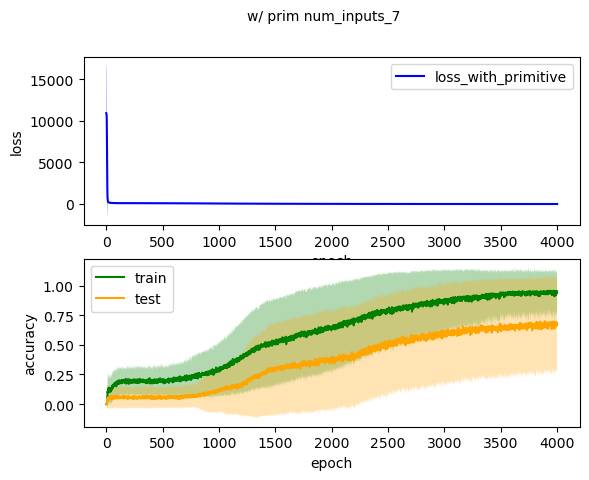

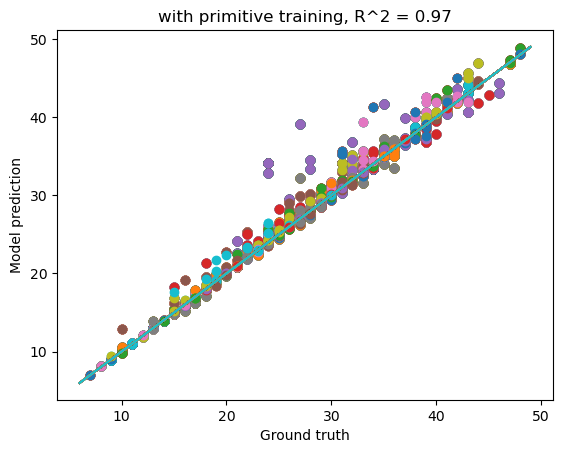

In [45]:
p = pad_seqs_1step(all_syms, cue_dict, padder = ('+', 'B'))
trainseqs = p + pad_seqs_2step(generate_min_other(ops, all_syms[1:], all_syms[1:]), padder = ('+', 'B'))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res7  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res7])
acc_train = np.array([r['acc'][:,0] for r in res7]).T
acc_test = np.array([r['acc'][:,1] for r in res7]).T
mods = [r['mod'] for r in res7]
tests = [r['test'] for r in res7]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# exp 6 - Min set of Xother

time:  5.831418867905935


label       pred  acc
trial                                             
['B', '+', 'E', '+', 'A']  27.5625  11.474965  0.0
['C', '+', 'B', '+', 'A']  27.6125  11.697050  0.0
['C', '+', 'E', '+', 'A']  27.2875  11.422873  0.0
['D', '+', 'D', '+', 'A']  28.9625  13.697098  0.0
['E', '+', 'A', '+', 'B']  27.5625  11.214925  0.0
['E', '+', 'A', '+', 'E']  27.2375  11.217595  0.0
['E', '+', 'C', '+', 'A']  27.2875  11.168586  0.0
['E', '+', 'E', '+', 'A']  27.2375  11.683907  0.0

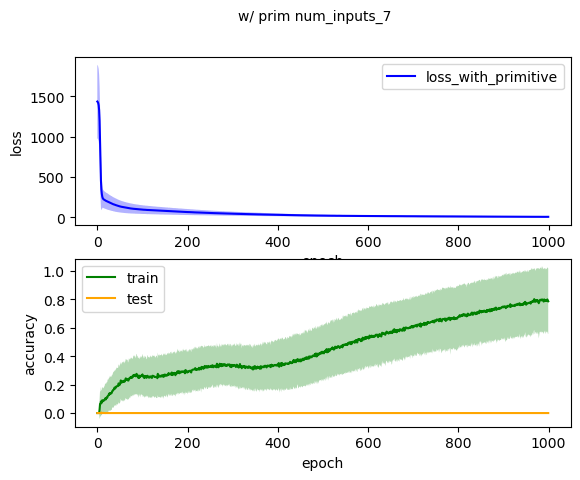

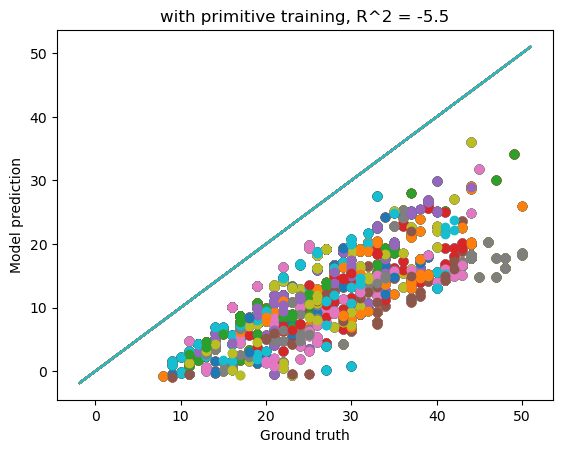

In [31]:
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_Xother(ops, all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

t1 = time.time()
res6  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res6])
acc_train = np.array([r['acc'][:,0] for r in res6]).T
acc_test = np.array([r['acc'][:,1] for r in res6]).T
mods = [r['mod'] for r in res6]
tests = [r['test'] for r in res6]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [18]:
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_min_other(ops, all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 5)

In [427]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        
        self.initialize_weights()

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)


time:  8.89250924984614


label       pred     acc
trial                                                
['C', '+', 'A', '+', 'D']  28.9375  27.442628  0.1250
['C', '+', 'F', '+', 'A']  27.1875  25.527601  0.0625
['D', '+', 'D', '+', 'A']  31.3750  29.783678  0.0625
['E', '+', 'B', '+', 'A']  26.1875  25.329617  0.0625
['C', '+', 'C', '+', 'A']  26.5000  24.721870  0.0000

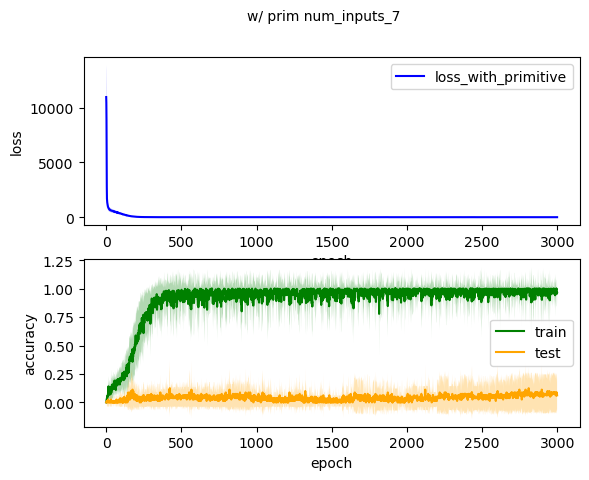

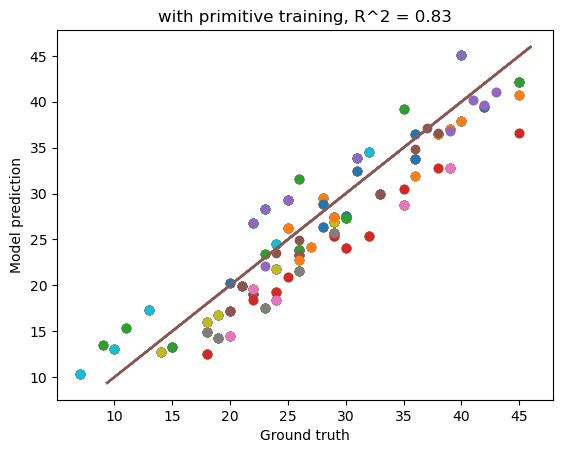

In [428]:
epochs = 3000
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = p + pad_seqs_2step(generate_other_1step(ops, all_syms[1:], all_syms[1:]))
testseqs = test_other(ops, 'A', all_syms[1:], rep = 5)

t1 = time.time()
res4  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res4])
acc_train = np.array([r['acc'][:,0] for r in res4]).T
acc_test = np.array([r['acc'][:,1] for r in res4]).T
mods = [r['mod'] for r in res4]
tests = [r['test'] for r in res4]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)